In [1]:
import os
import yaml
import json

os.chdir('/home/ray/DeepMSN/')

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from datasets.topic_datasets import TopicDataset
# from models.deepmsn import DeepMSN

device = torch.device(f'cuda:0')
print(f"Using {device} device")

Using cuda:0 device


In [2]:
with open('configs/config_dm-ctdnsmpl_top3k_dm_ctdnsmpl_3k_2025-05-30_03-28-45.yaml', 'r') as f:
    config = yaml.safe_load(f)

checkpoint_path = config.get('train').get('checkpoint').get('path')
checkpoint_path

'checkpoints/dm_ctdnsmpl_3k_2025-05-30_03-28-45'

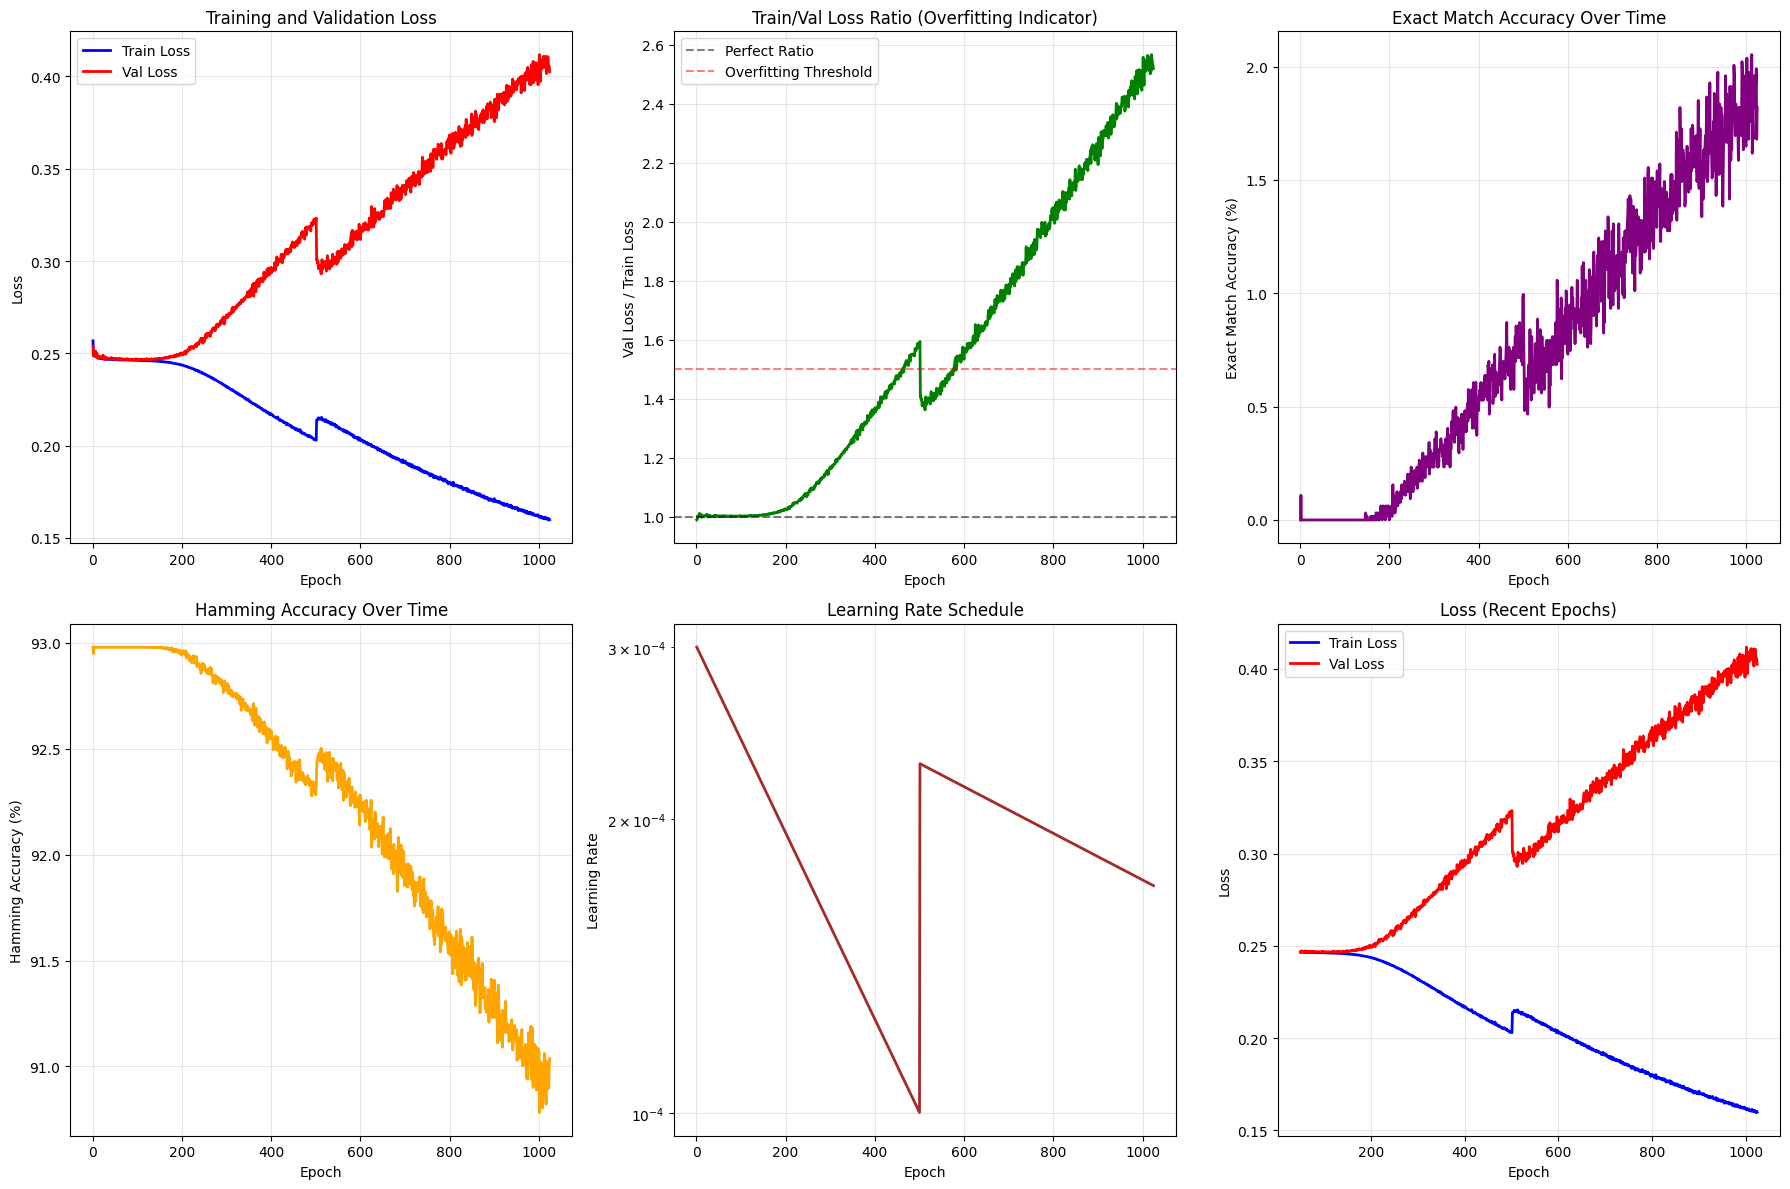

Training Summary:
Initial Train Loss: 0.256720
Final Train Loss: 0.159781
Initial Val Loss: 0.253844
Final Val Loss: 0.402536
Best Val Loss: 0.246450 (Epoch 85)
Best Exact Match Acc: 0.0205 (Epoch 1012)
Best Hamming Acc: 0.9298 (Epoch 148)
Final Train/Val Ratio: 2.519


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the training log
training_df = pd.read_csv(f'{checkpoint_path}/training_log.csv')

# Create comprehensive training plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training and Validation Loss
axes[0, 0].plot(training_df['epoch'], training_df['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(training_df['epoch'], training_df['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Train/Val Loss Ratio (Overfitting indicator)
axes[0, 1].plot(training_df['epoch'], training_df['train_val_ratio'], 'g-', linewidth=2)
axes[0, 1].axhline(y=1.0, color='k', linestyle='--', alpha=0.5, label='Perfect Ratio')
axes[0, 1].axhline(y=1.5, color='r', linestyle='--', alpha=0.5, label='Overfitting Threshold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Val Loss / Train Loss')
axes[0, 1].set_title('Train/Val Loss Ratio (Overfitting Indicator)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Exact Match Accuracy
axes[0, 2].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 'purple', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Exact Match Accuracy (%)')
axes[0, 2].set_title('Exact Match Accuracy Over Time')
axes[0, 2].grid(True, alpha=0.3)

# 4. Hamming Accuracy
axes[1, 0].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 'orange', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Hamming Accuracy (%)')
axes[1, 0].set_title('Hamming Accuracy Over Time')
axes[1, 0].grid(True, alpha=0.3)

# 5. Learning Rate Schedule
axes[1, 1].plot(training_df['epoch'], training_df['learning_rate'], 'brown', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Comparison (zoomed view of recent epochs)
recent_epochs = training_df['epoch'] >= 50  # Show last part of training
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[1, 2].plot(training_df[recent_epochs]['epoch'], 
                training_df[recent_epochs]['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_title('Loss (Recent Epochs)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print(f"Initial Train Loss: {training_df['train_loss'].iloc[0]:.6f}")
print(f"Final Train Loss: {training_df['train_loss'].iloc[-1]:.6f}")
print(f"Initial Val Loss: {training_df['val_loss'].iloc[0]:.6f}")
print(f"Final Val Loss: {training_df['val_loss'].iloc[-1]:.6f}")
print(f"Best Val Loss: {training_df['val_loss'].min():.6f} (Epoch {training_df.loc[training_df['val_loss'].idxmin(), 'epoch']})")
print(f"Best Exact Match Acc: {training_df['exact_match_acc'].max():.4f} (Epoch {training_df.loc[training_df['exact_match_acc'].idxmax(), 'epoch']})")
print(f"Best Hamming Acc: {training_df['hamming_acc'].max():.4f} (Epoch {training_df.loc[training_df['hamming_acc'].idxmax(), 'epoch']})")
print(f"Final Train/Val Ratio: {training_df['train_val_ratio'].iloc[-1]:.3f}")

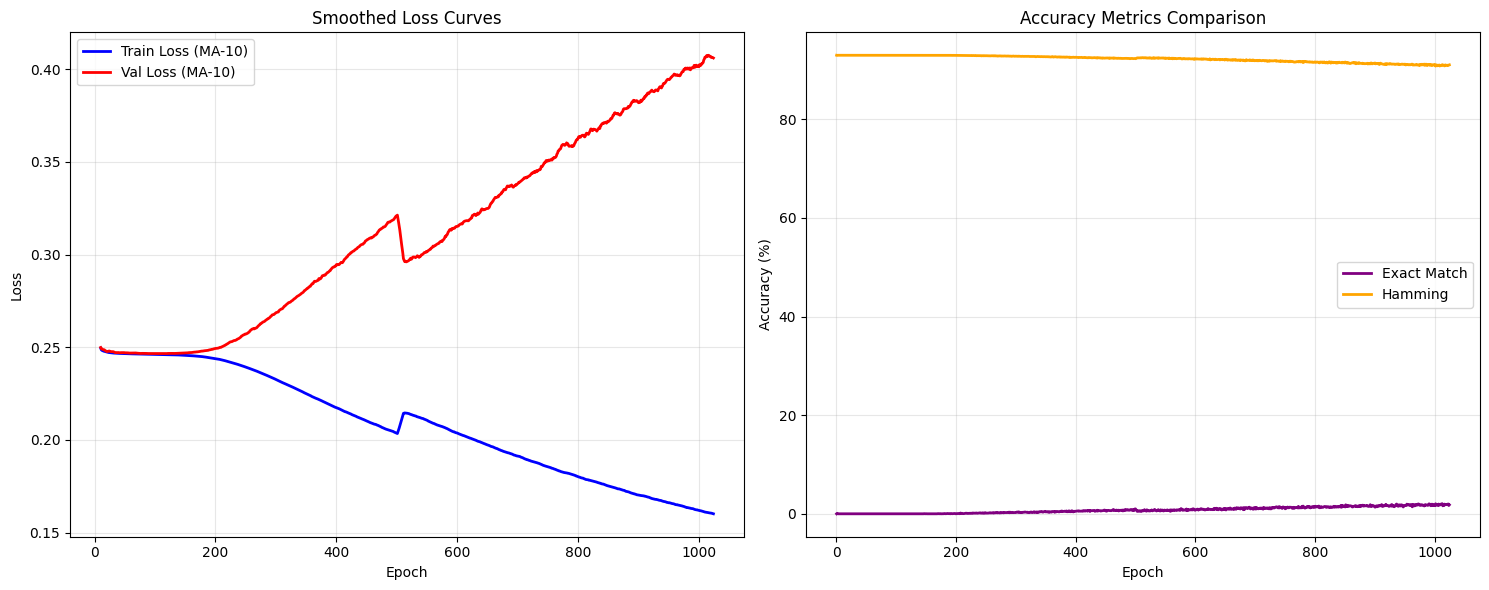

In [4]:
# Additional analysis plots

# Plot 1: Loss improvement over time
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Moving average to smooth curves
window = 10
train_loss_smooth = training_df['train_loss'].rolling(window=window).mean()
val_loss_smooth = training_df['val_loss'].rolling(window=window).mean()

axes[0].plot(training_df['epoch'], train_loss_smooth, 'b-', label=f'Train Loss (MA-{window})', linewidth=2)
axes[0].plot(training_df['epoch'], val_loss_smooth, 'r-', label=f'Val Loss (MA-{window})', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Smoothed Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(training_df['epoch'], training_df['exact_match_acc'] * 100, 
             'purple', label='Exact Match', linewidth=2)
axes[1].plot(training_df['epoch'], training_df['hamming_acc'] * 100, 
             'orange', label='Hamming', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Metrics Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

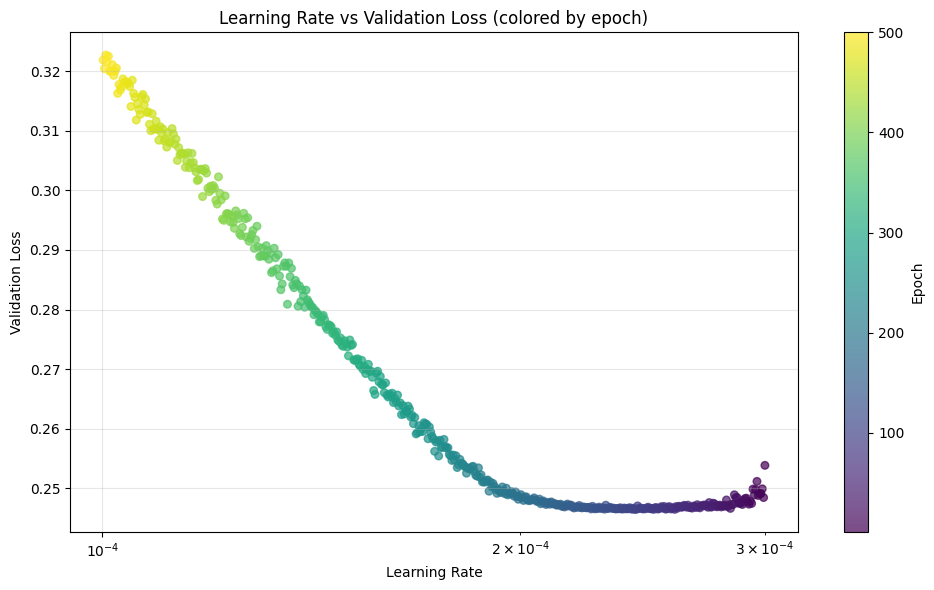

In [6]:
# Learning rate vs loss correlation
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create scatter plot with color gradient
scatter = ax.scatter(training_df['learning_rate'], training_df['val_loss'], 
                    c=training_df['epoch'], cmap='viridis', alpha=0.7, s=30)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_title('Learning Rate vs Validation Loss (colored by epoch)')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Epoch')

plt.tight_layout()
plt.show()

In [9]:
# # Training phases analysis
# print("Training Phases Analysis:")
# print("=" * 50)

# # Phase 1: Initial training (epochs 1-50)
# phase1 = training_df[training_df['epoch'] <= 50]
# print(f"Phase 1 (Epochs 1-50):")
# print(f"  Loss reduction: {phase1['train_loss'].iloc[0]:.4f} → {phase1['train_loss'].iloc[-1]:.4f}")
# print(f"  Val loss reduction: {phase1['val_loss'].iloc[0]:.4f} → {phase1['val_loss'].iloc[-1]:.4f}")
# print(f"  Accuracy improvement: {phase1['exact_match_acc'].iloc[0]:.4f} → {phase1['exact_match_acc'].iloc[-1]:.4f}")

# # Phase 2: Middle training (epochs 51-200)
# phase2 = training_df[(training_df['epoch'] > 50) & (training_df['epoch'] <= 200)]
# print(f"\nPhase 2 (Epochs 51-200):")
# print(f"  Loss reduction: {phase2['train_loss'].iloc[0]:.4f} → {phase2['train_loss'].iloc[-1]:.4f}")
# print(f"  Val loss reduction: {phase2['val_loss'].iloc[0]:.4f} → {phase2['val_loss'].iloc[-1]:.4f}")
# print(f"  Best accuracy: {phase2['exact_match_acc'].max():.4f}")

# # Phase 3: Fine-tuning (epochs 201-300)
# phase3 = training_df[training_df['epoch'] > 200]
# print(f"\nPhase 3 (Epochs 201-300):")
# print(f"  Loss reduction: {phase3['train_loss'].iloc[0]:.4f} → {phase3['train_loss'].iloc[-1]:.4f}")
# print(f"  Val loss reduction: {phase3['val_loss'].iloc[0]:.4f} → {phase3['val_loss'].iloc[-1]:.4f}")
# print(f"  Best accuracy: {phase3['exact_match_acc'].max():.4f}")

# # Identify potential overfitting
# overfitting_epochs = training_df[training_df['train_val_ratio'] > 1.5]
# if len(overfitting_epochs) > 0:
#     print(f"\nPotential overfitting detected in {len(overfitting_epochs)} epochs:")
#     print(f"  First occurrence: Epoch {overfitting_epochs['epoch'].iloc[0]}")
#     print(f"  Worst ratio: {overfitting_epochs['train_val_ratio'].max():.3f} at epoch {overfitting_epochs.loc[overfitting_epochs['train_val_ratio'].idxmax(), 'epoch']}")
# else:
#     print(f"\nNo significant overfitting detected (all ratios < 1.5)")

In [7]:
# Determine model used
model_arch = config.get('train').get('model')

if model_arch == 'DeepMSN':
    from models.deepmsn import DeepMSN
    ModelClass = DeepMSN
elif model_arch == 'DeepFlyBrain':
    from models.deepflybrain import DeepFlyBrain
    ModelClass = DeepFlyBrain

In [8]:
# Load model from checkpoint
state_dict = torch.load(f'{checkpoint_path}/final_model.pth')

model = ModelClass(config=config).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
# Resume dataset and dataloaders from saved indices
batch_size = 64
dataset = TopicDataset(config=config['dataset'])

with open(f'{checkpoint_path}/test_indices.txt', 'r') as f:
    test_indices = [int(line.strip()) for line in f.readlines()]
test_dataset = torch.utils.data.Subset(dataset, test_indices)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Entire dataset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)  # Test dataset

In [14]:
# Loss function
# Label smoothing loss to prevent overconfident predictions
class LabelSmoothingBCELoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        # Apply label smoothing: y_smooth = y * (1-α) + α/2
        target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
        return self.bce(pred, target_smooth)

loss_fn = LabelSmoothingBCELoss(smoothing=0.1)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

In [14]:
# Evaluate model on entire dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [16]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 1.3951785e-09 0.9878247
Prediction shape: (30179, 18)
Target shape: (30179, 18)


In [17]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0663
Topic 1: 0.0662
Topic 2: 0.0663
Topic 3: 0.0663
Topic 4: 0.0663
Topic 5: 0.0663
Topic 6: 0.0663
Topic 7: 0.0663
Topic 8: 0.0662
Topic 9: 0.0663
Topic 10: 0.0663
Topic 11: 0.0663
Topic 12: 0.0663
Topic 13: 0.0663
Topic 14: 0.0662
Topic 15: 0.0663
Topic 16: 0.0663
Topic 17: 0.0663


In [18]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[28177     2]
 [ 1998     2]]

Topic 1:
[[28175     5]
 [ 1994     5]]

Topic 2:
[[28176     3]
 [ 1997     3]]

Topic 3:
[[28167    12]
 [ 1995     5]]

Topic 4:
[[28176     3]
 [ 1998     2]]

Topic 5:
[[28171     8]
 [ 1993     7]]

Topic 6:
[[28176     3]
 [ 1997     3]]

Topic 7:
[[28171     8]
 [ 1995     5]]

Topic 8:
[[28156    24]
 [ 1989    10]]

Topic 9:
[[28172     7]
 [ 1994     6]]

Topic 10:
[[28176     3]
 [ 1996     4]]

Topic 11:
[[28169    10]
 [ 1987    13]]

Topic 12:
[[28177     2]
 [ 1996     4]]

Topic 13:
[[28178     1]
 [ 1997     3]]

Topic 14:
[[28131    49]
 [ 1971    28]]

Topic 15:
[[28179     0]
 [ 2000     0]]

Topic 16:
[[28172     7]
 [ 1994     6]]

Topic 17:
[[28170     9]
 [ 1996     4]]



Evaluating 18 topics...
Evaluating topic 0
Topic 0 - auROC: 0.6464, auPR: 0.1053, F1: 0.0020


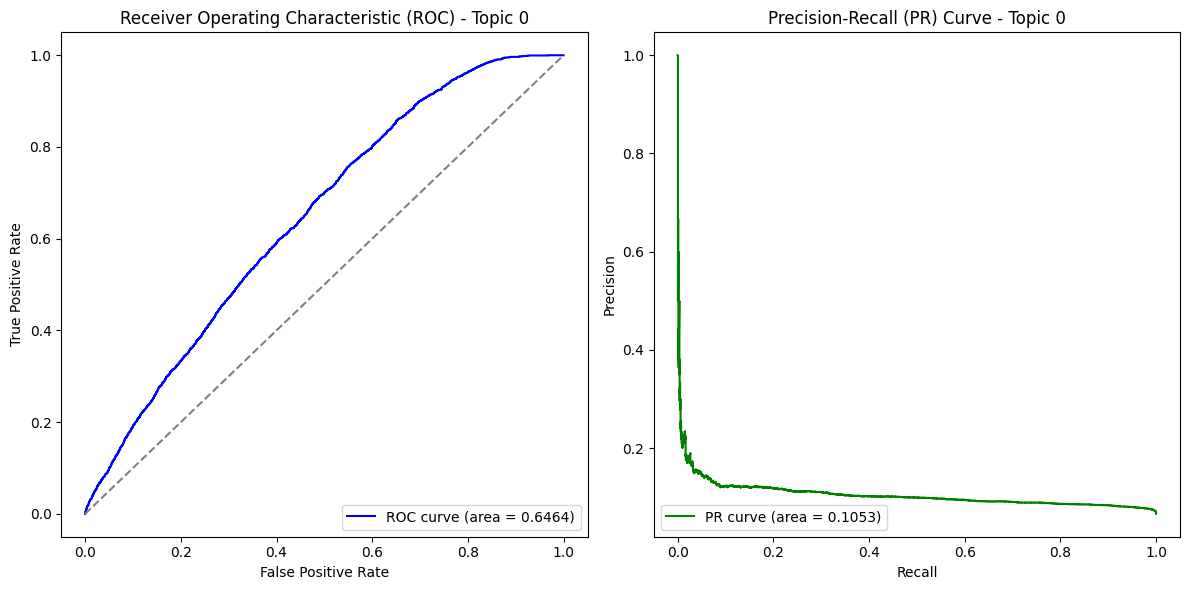

Evaluating topic 1
Topic 1 - auROC: 0.6702, auPR: 0.1300, F1: 0.0050


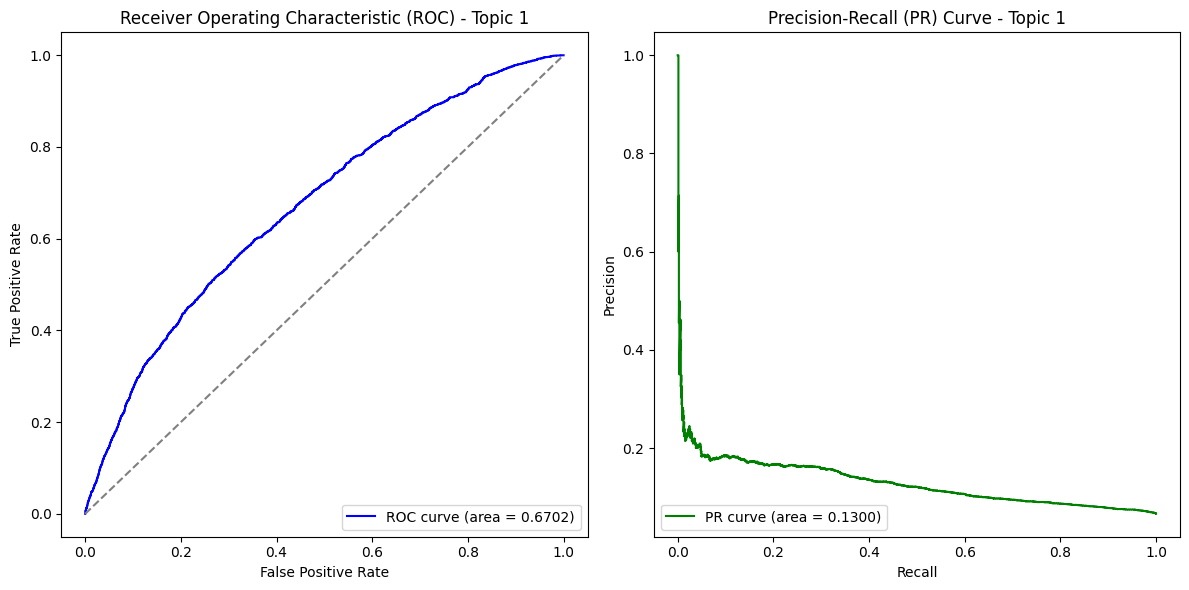

Evaluating topic 2
Topic 2 - auROC: 0.6109, auPR: 0.0953, F1: 0.0030


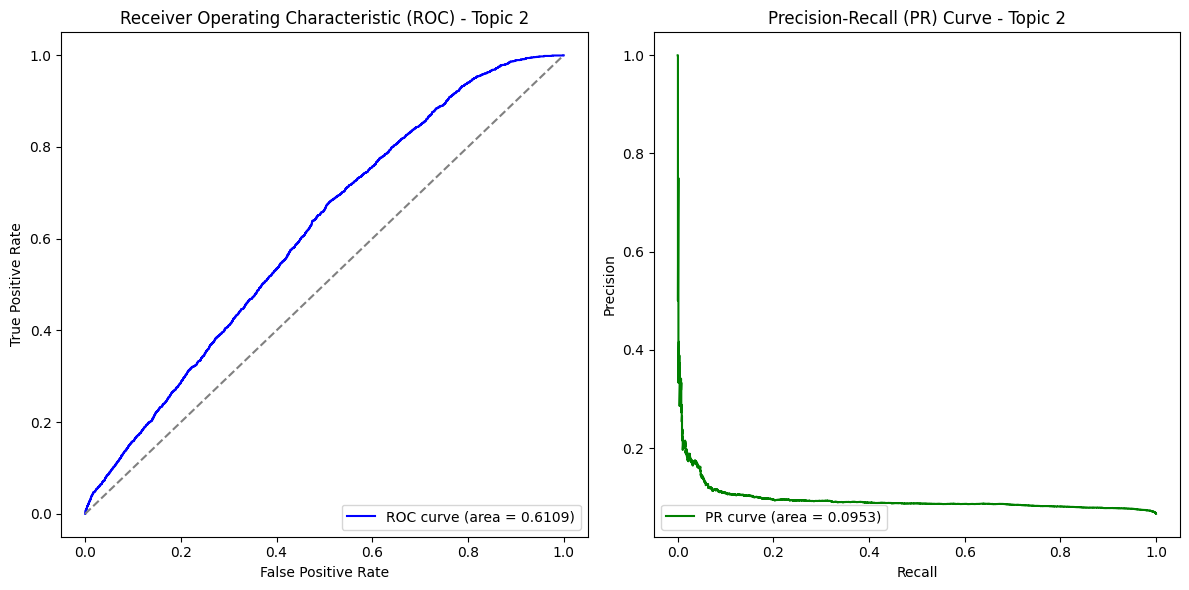

Evaluating topic 3
Topic 3 - auROC: 0.5758, auPR: 0.0894, F1: 0.0050


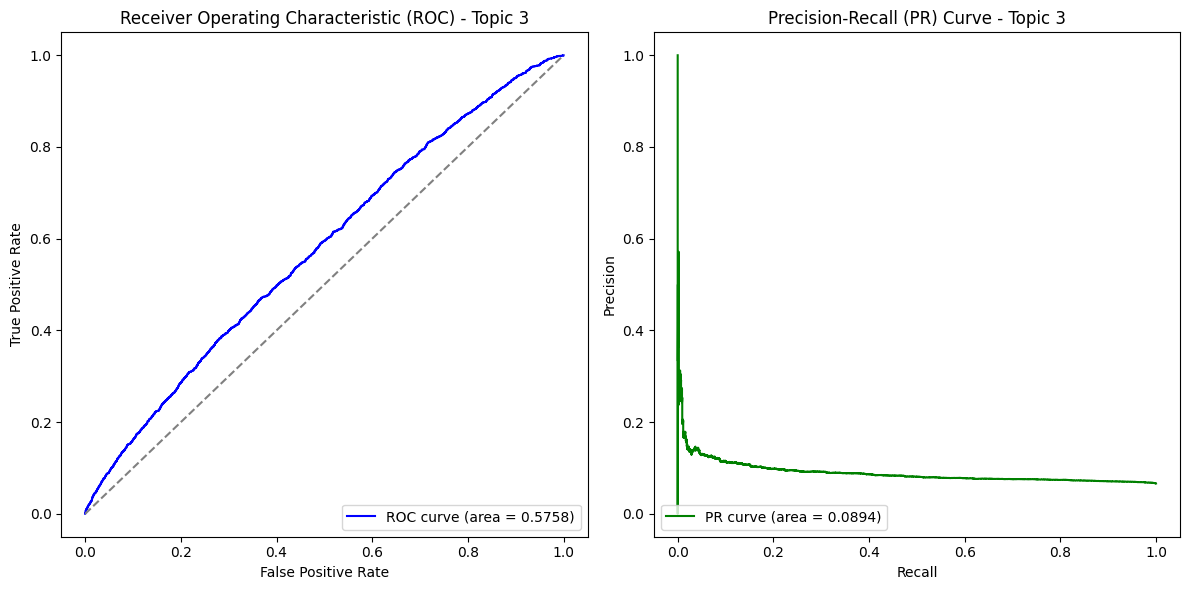

Evaluating topic 4
Topic 4 - auROC: 0.7271, auPR: 0.1539, F1: 0.0020


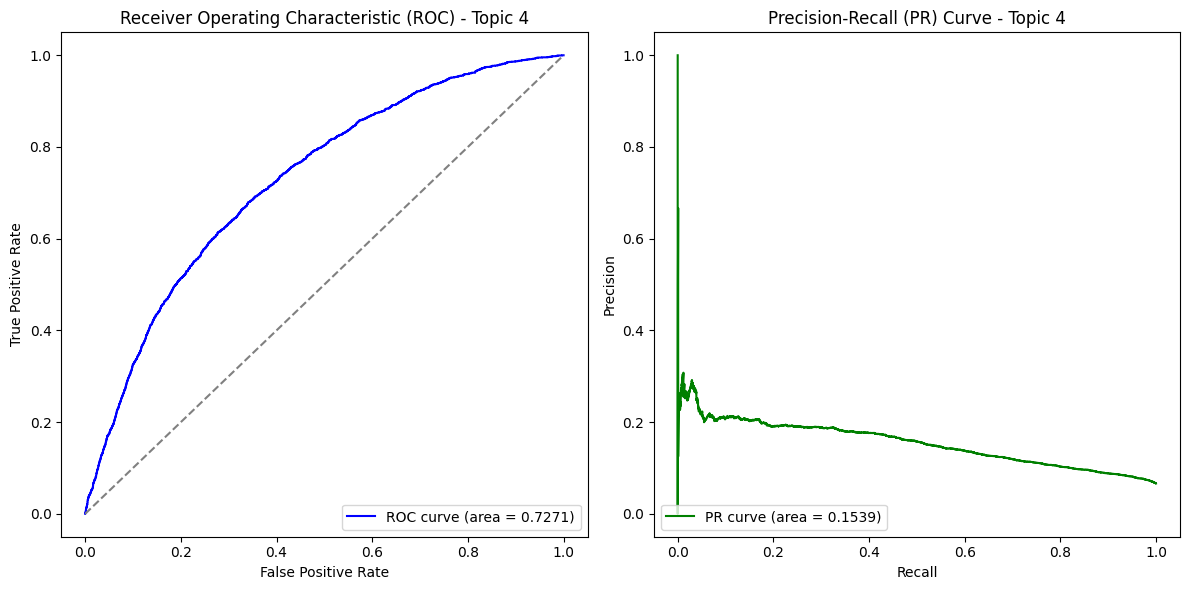

Evaluating topic 5
Topic 5 - auROC: 0.5930, auPR: 0.0934, F1: 0.0069


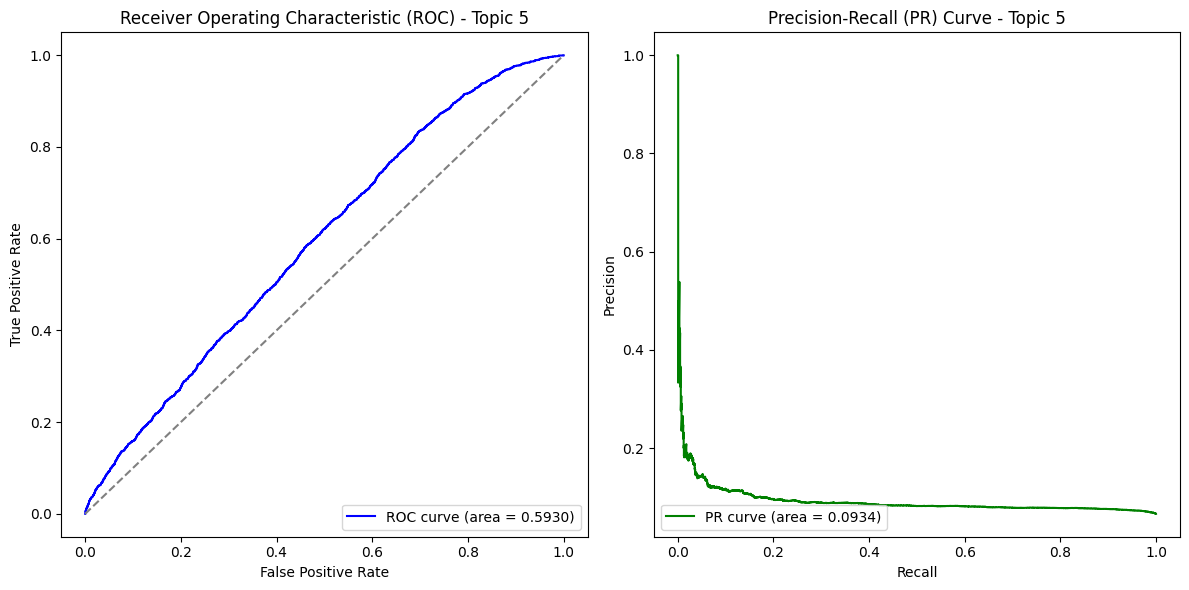

Evaluating topic 6
Topic 6 - auROC: 0.6416, auPR: 0.1053, F1: 0.0030


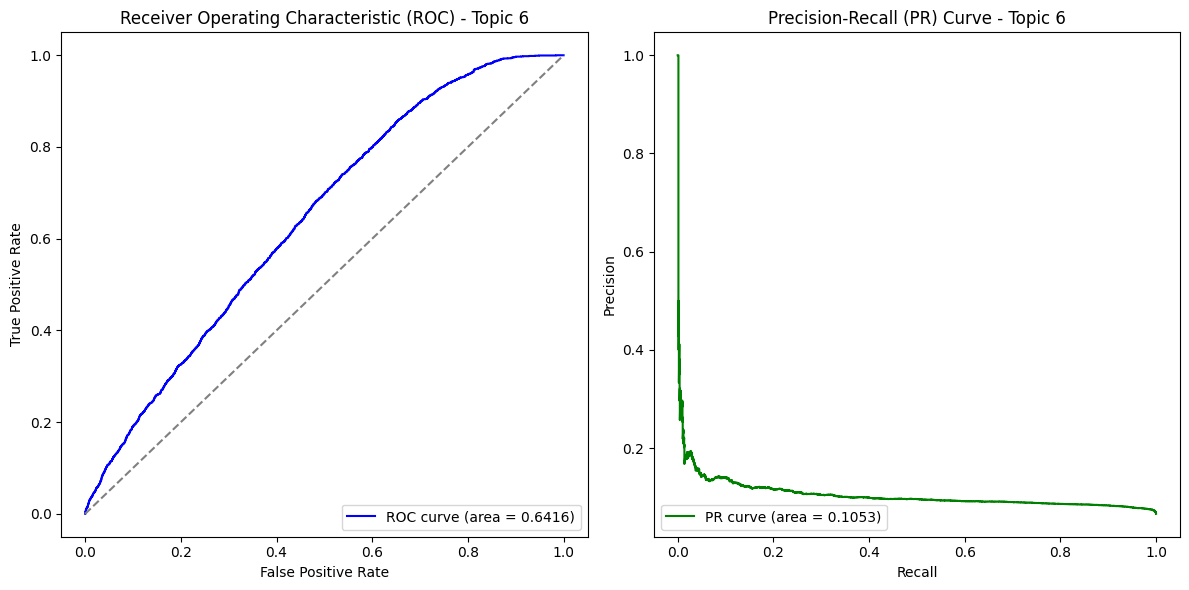

Evaluating topic 7
Topic 7 - auROC: 0.6238, auPR: 0.1018, F1: 0.0050


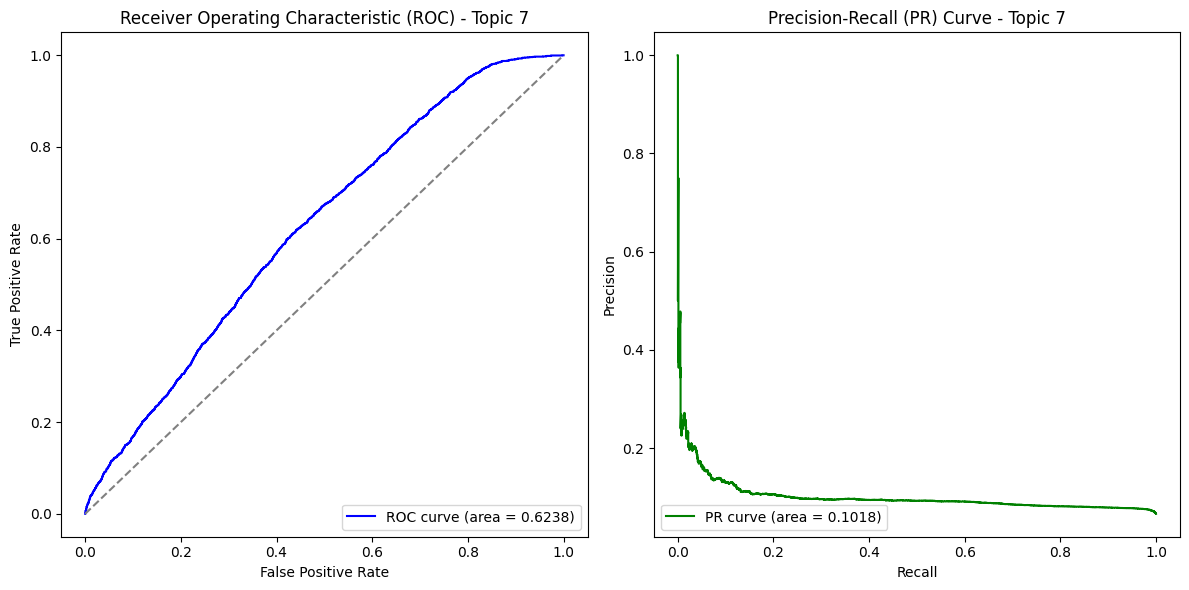

Evaluating topic 8
Topic 8 - auROC: 0.6388, auPR: 0.1225, F1: 0.0098


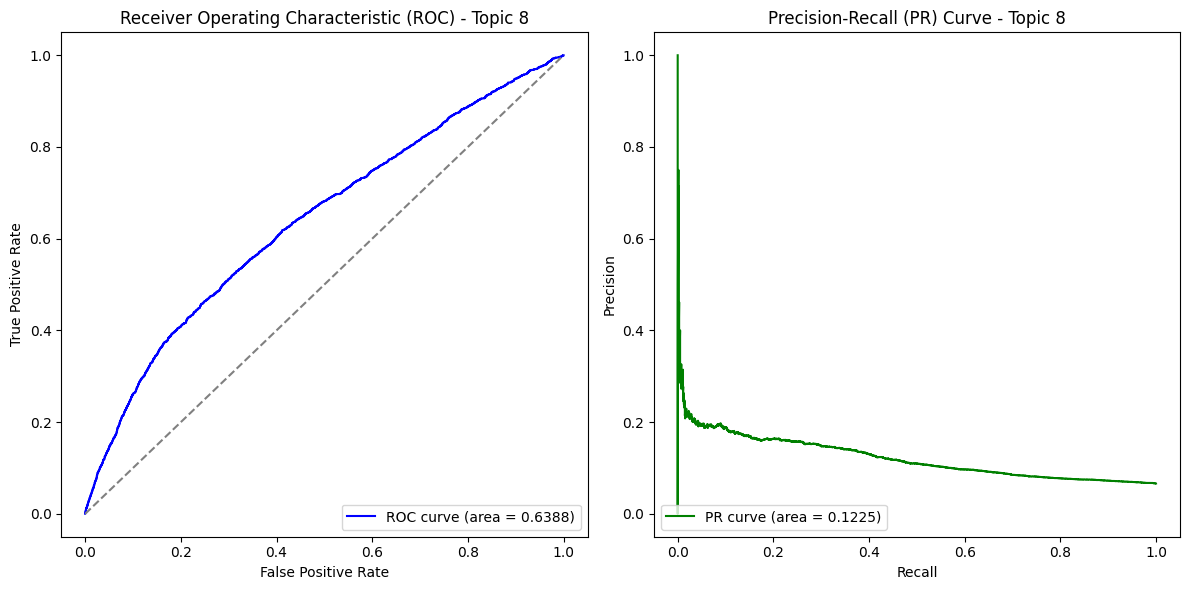

Evaluating topic 9
Topic 9 - auROC: 0.6399, auPR: 0.1088, F1: 0.0060


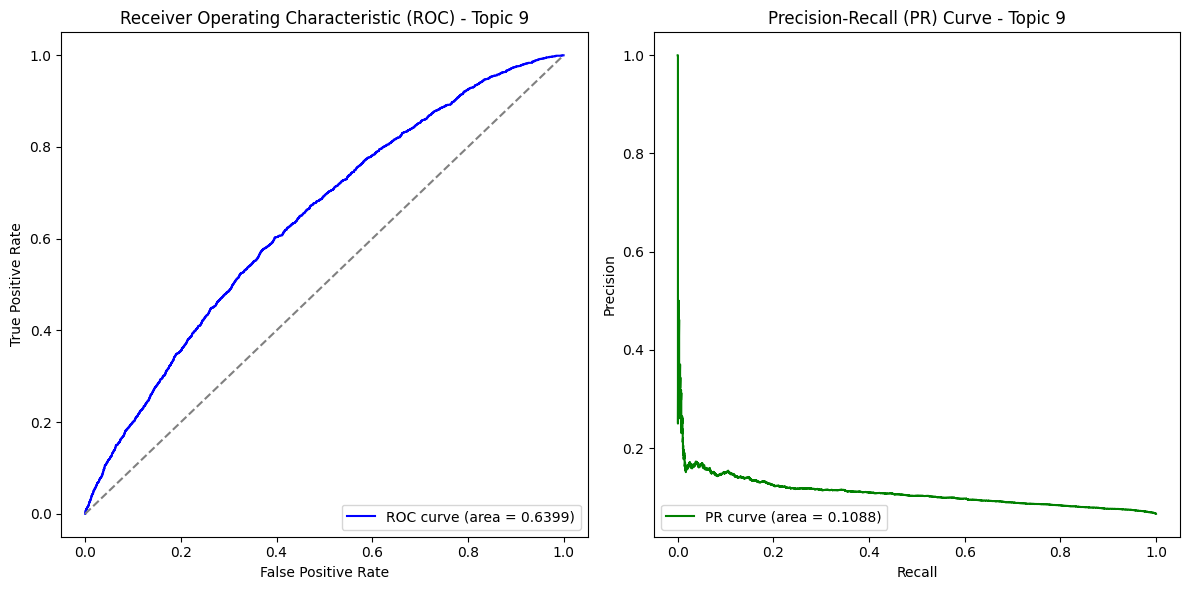

Evaluating topic 10
Topic 10 - auROC: 0.6727, auPR: 0.1347, F1: 0.0040


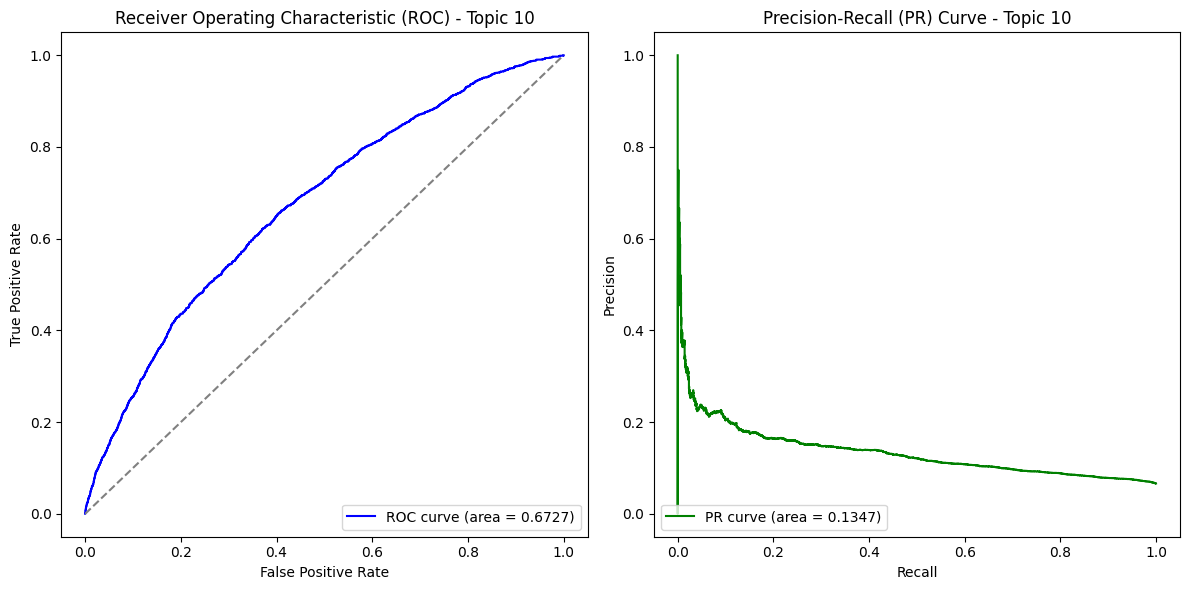

Evaluating topic 11
Topic 11 - auROC: 0.6611, auPR: 0.1348, F1: 0.0129


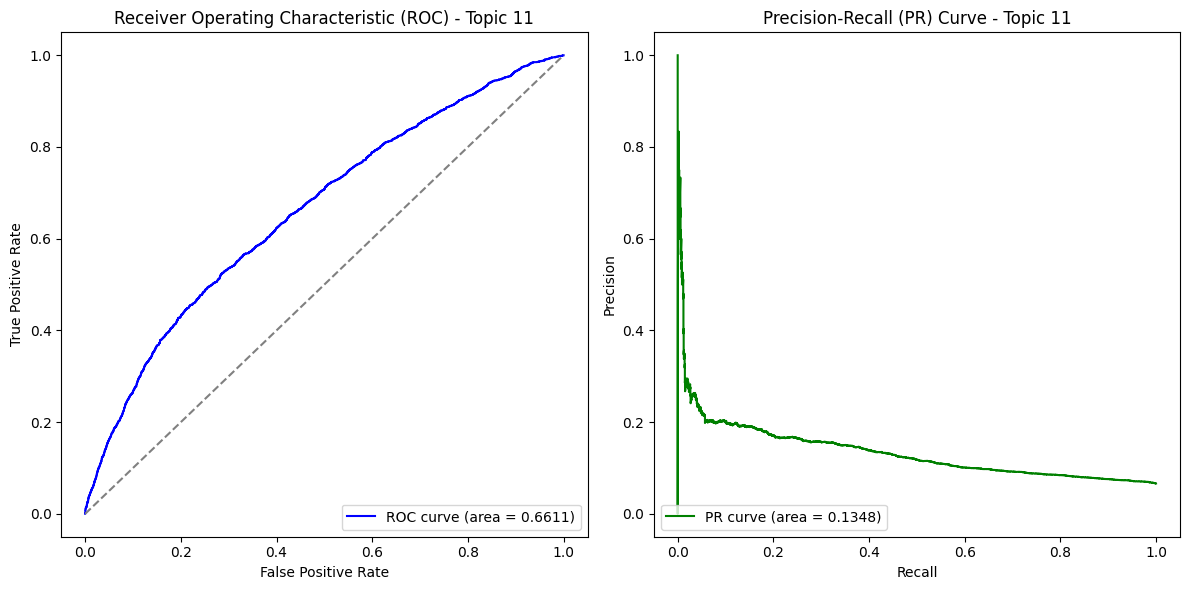

Evaluating topic 12
Topic 12 - auROC: 0.6085, auPR: 0.1013, F1: 0.0040


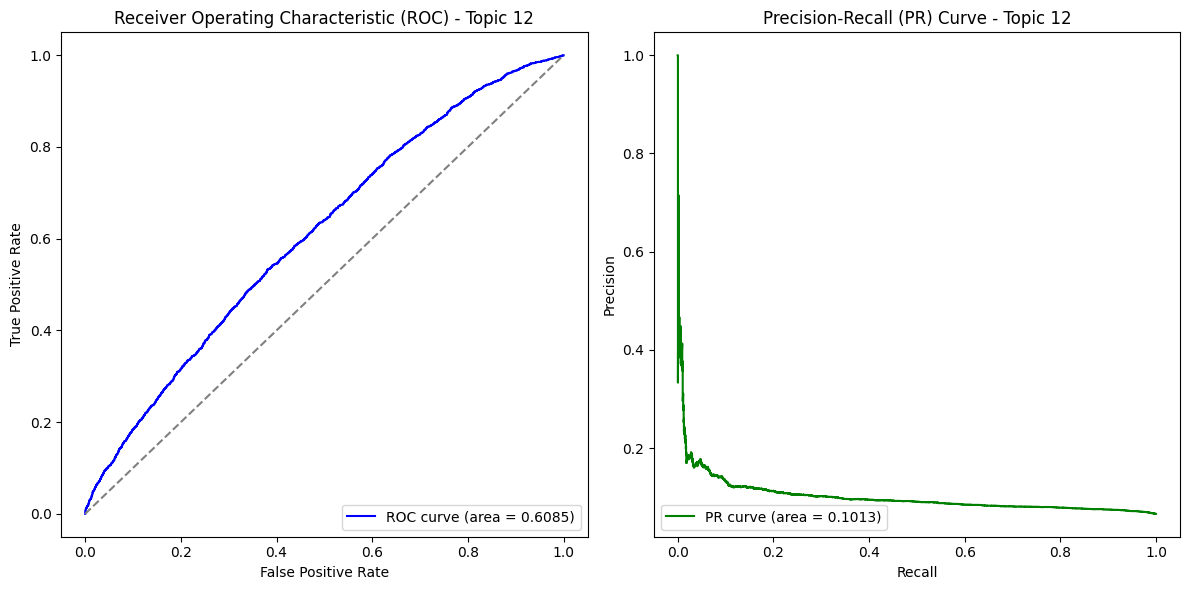

Evaluating topic 13
Topic 13 - auROC: 0.6644, auPR: 0.1158, F1: 0.0030


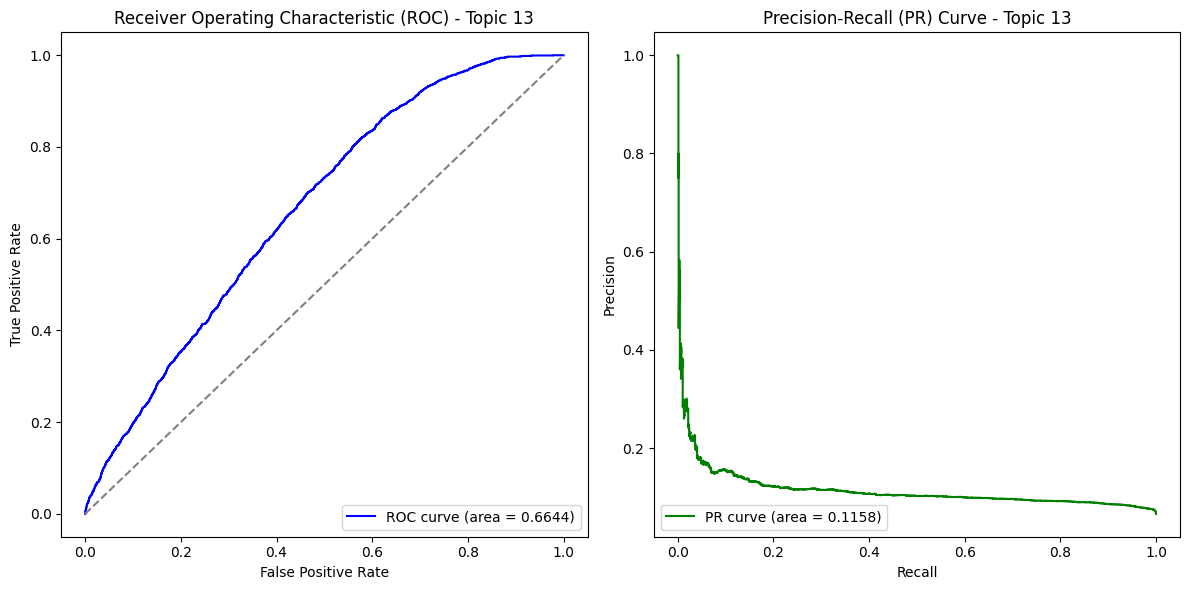

Evaluating topic 14
Topic 14 - auROC: 0.6499, auPR: 0.1287, F1: 0.0270


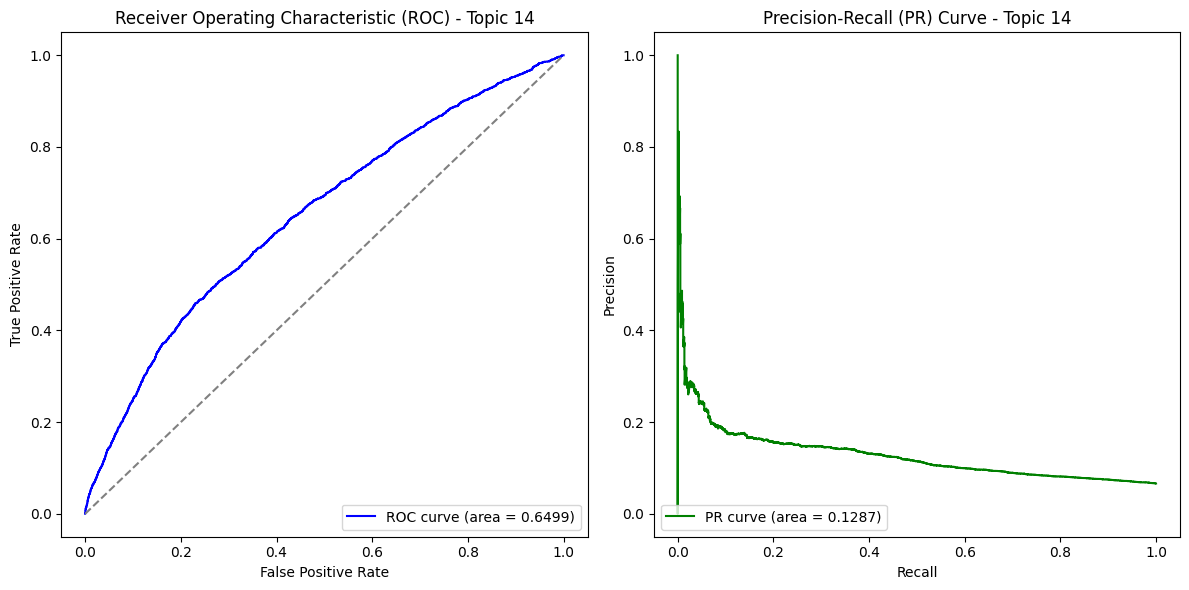

Evaluating topic 15
Topic 15 - auROC: 0.6289, auPR: 0.1026, F1: 0.0000


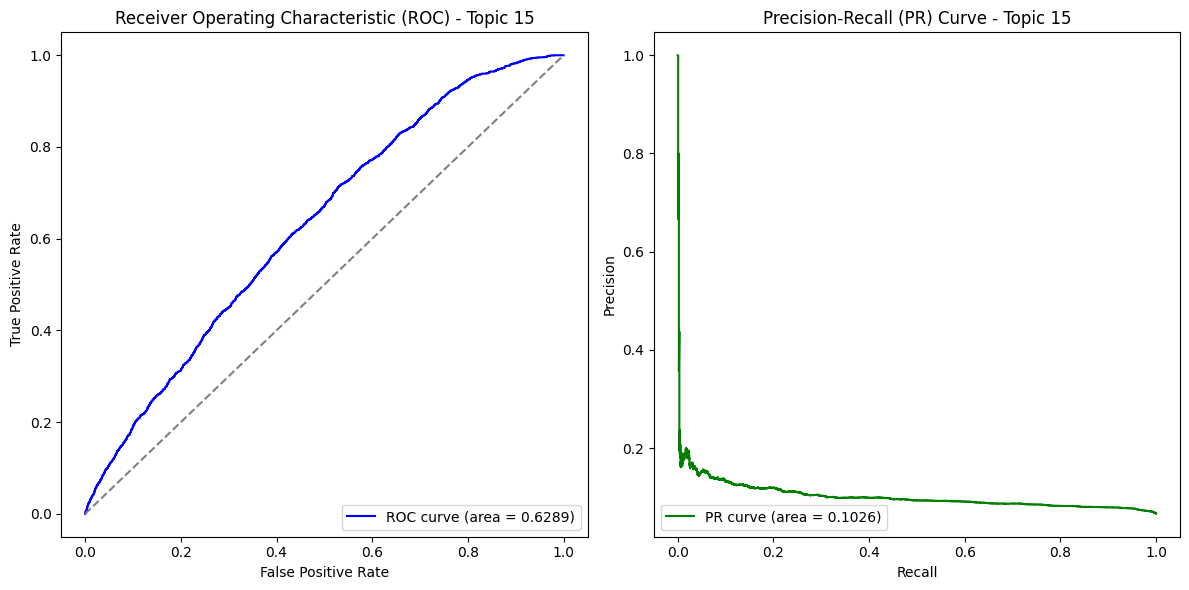

Evaluating topic 16
Topic 16 - auROC: 0.6834, auPR: 0.1264, F1: 0.0060


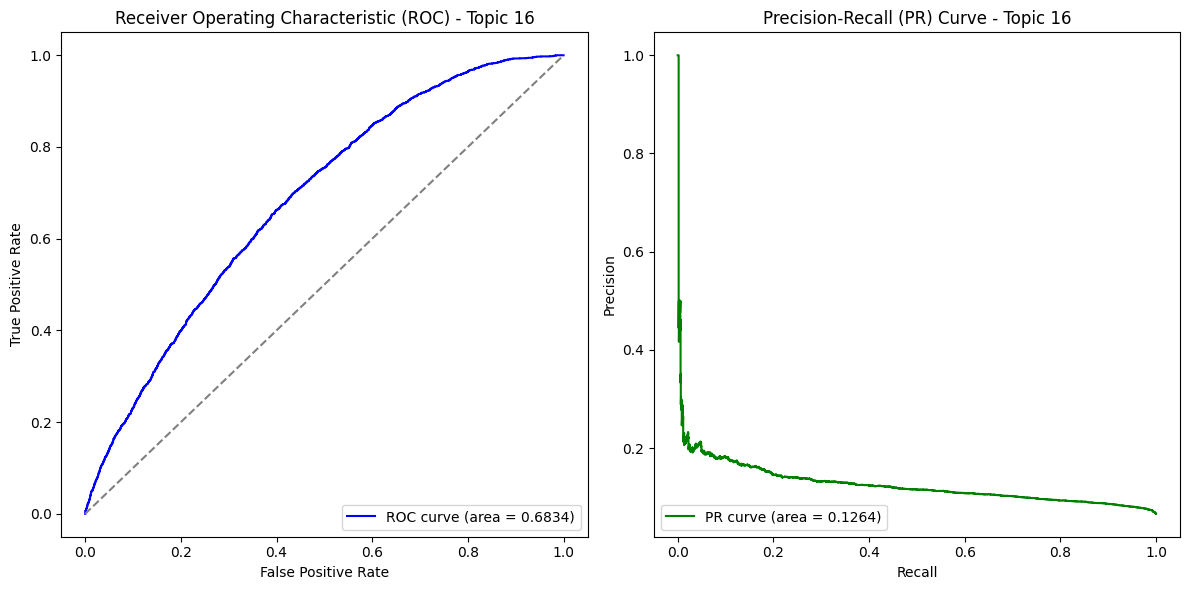

Evaluating topic 17
Topic 17 - auROC: 0.6263, auPR: 0.0984, F1: 0.0040


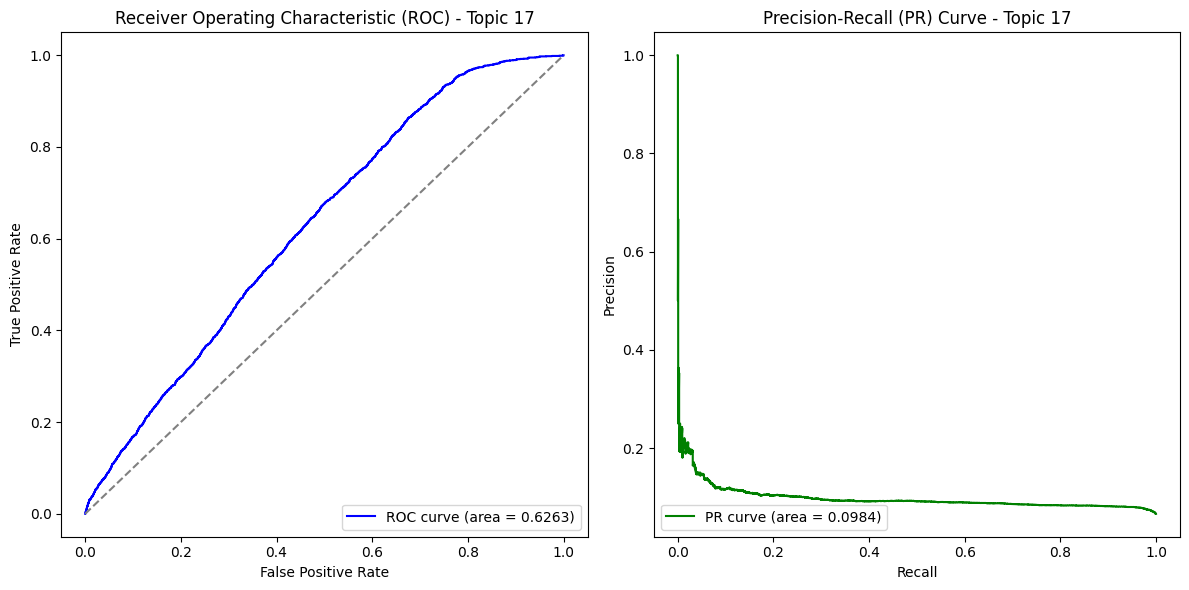

In [19]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [20]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.6424 ± 0.0344
Mean auPR: 0.1138 ± 0.0173
Mean F1: 0.0060 ± 0.0058
Exact Match Accuracy: 0.0027
Hamming Accuracy: 0.9336


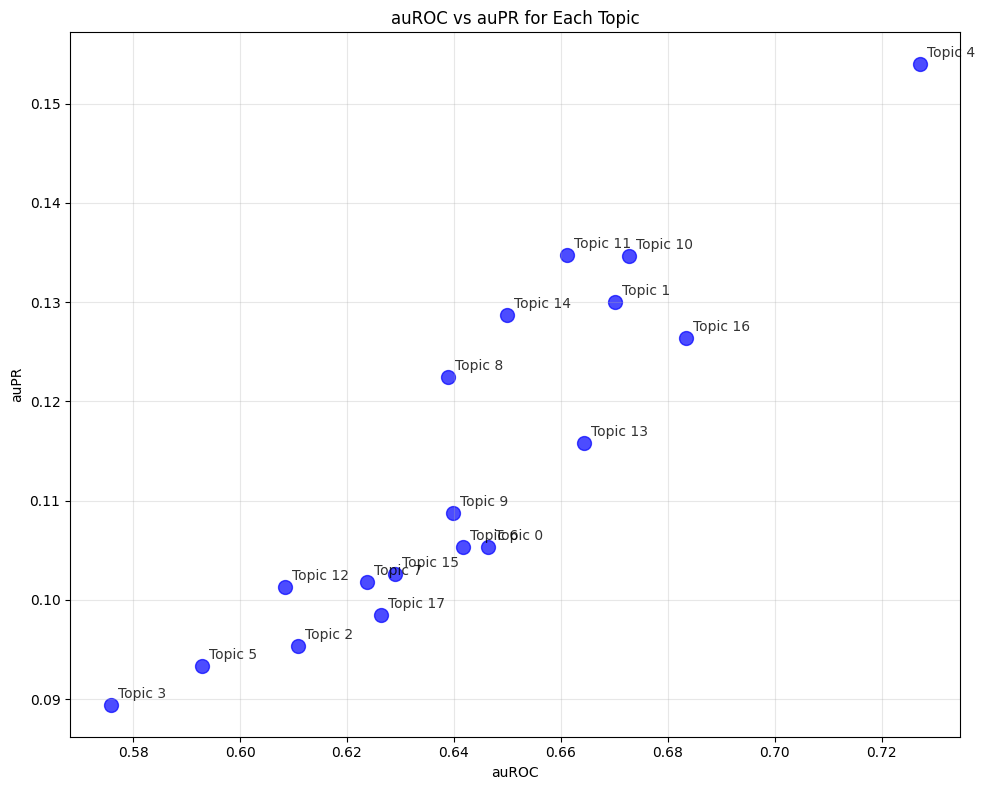

In [21]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

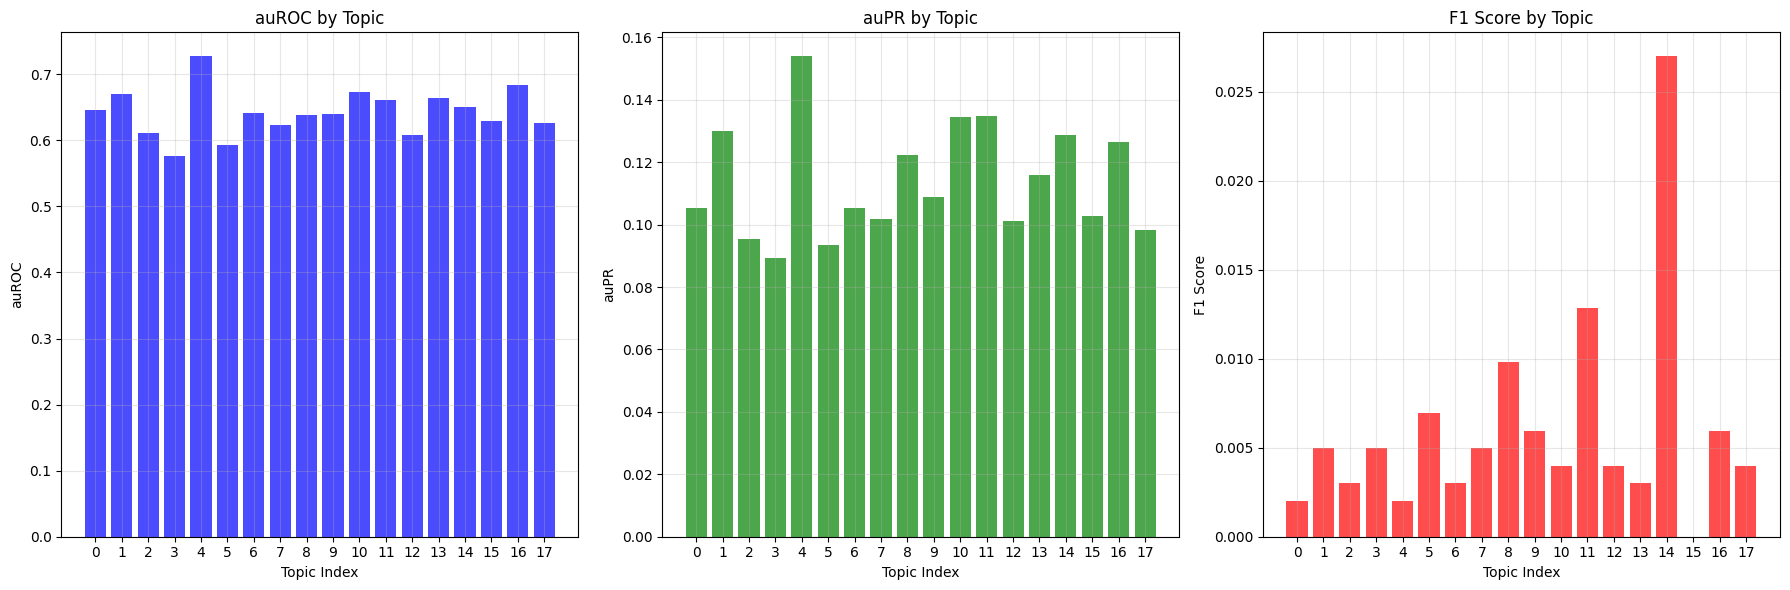

In [22]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

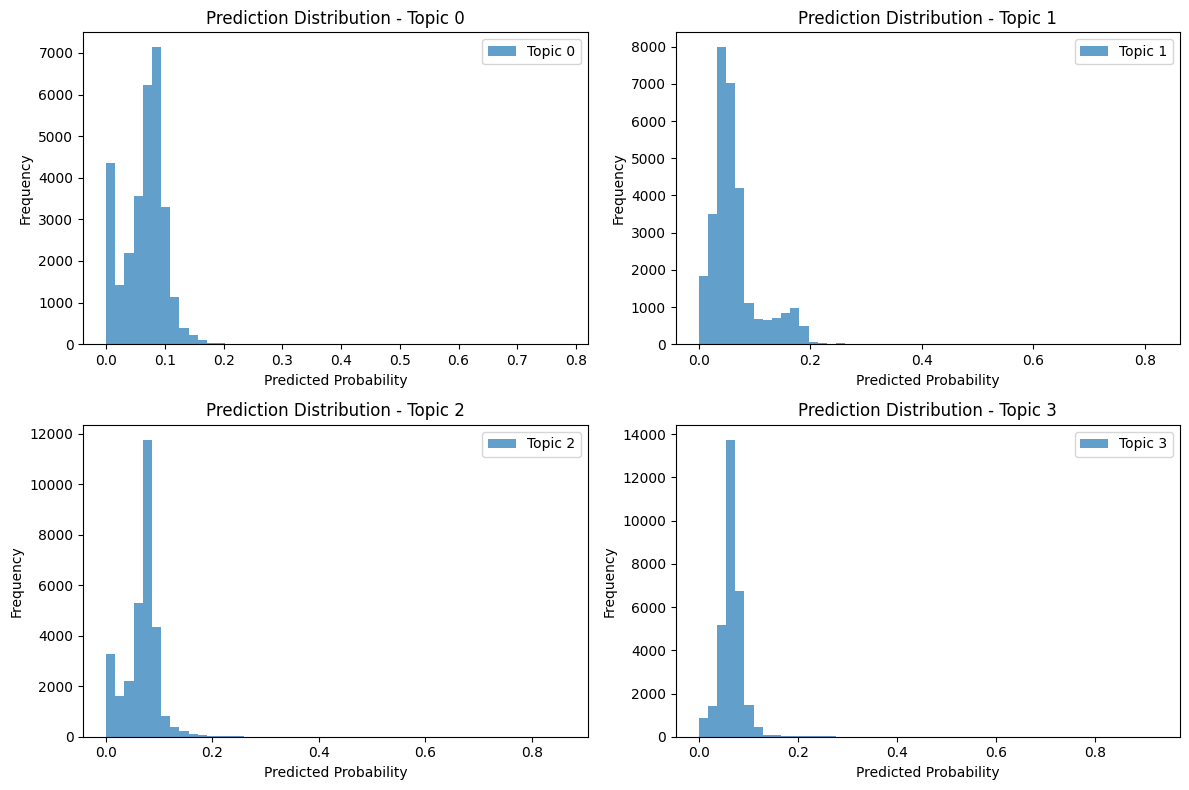


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.0592528  0.03969448 0.07240799 0.06742474 0.01877763 0.07070505
 0.05670401 0.07870075 0.04787278 0.11627379 0.0382706  0.02815872
 0.09554268 0.04520771 0.05652926 0.10192962 0.11241736 0.06262463]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [1.7152836e-04 2.2313127e-02 1.6032750e-02 3.4176785e-02 2.4153647e-01
 2.4782352e-02 1.5846904e-03 1.3592499e-03 1.7412613e-01 1.4712921e-02
 1.5393579e-01 8.4327616e-02 5.4913394e-02 1.0248238e-03 2.6435193e-01
 1.6158483e-03 2.3835793e-03 2.7260955e-02]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.0003374  0.15568501 0.00147039 0.05138162 0.27428916 0.0053196
 0.00062653 0.00185529 0.16061829 0.0077474  0.21919312 0.11274283
 0.02973623 0.00035914 0.15089862 0.00237519 0.00084541 0

In [23]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()

In [15]:
# Evaluate model on test dataset
model.eval()

loss, correct = 0, 0
all_test_probs = []
all_test_targets = []

with torch.no_grad():
    for batch in test_dataloader:
        X, y = batch['sequence'], batch['label']
        X, y = X.to(device), y.to(device)
        y = y.float()
        
        pred = model(X)
        prob = torch.sigmoid(pred)
        loss += loss_fn(pred, y).item()
        
        all_test_probs.append(prob)
        all_test_targets.append(y)
        
        # Exact match accuracy
        pred_binary = (prob > 0.5).float()
        exact_match = ((pred_binary == y).sum(dim=1) == y.shape[1]).float().sum().item()
        correct += exact_match

all_test_probs = torch.cat(all_test_probs, dim=0)
all_test_targets = torch.cat(all_test_targets, dim=0)

loss /= len(test_dataloader)
exact_acc = correct / len(dataset)

pred_binary = (all_test_probs > 0.5).float()
hamming_acc = (pred_binary == all_test_targets).float().mean().item()

In [16]:
# Convert PyTorch tensors to numpy for sklearn
y_pred_np = all_test_probs.cpu().numpy()
y_test_np = all_test_targets.cpu().numpy()

print("Prediction min/max:", np.min(y_pred_np), np.max(y_pred_np))
print("Prediction shape:", y_pred_np.shape)
print("Target shape:", y_test_np.shape)

Prediction min/max: 2.3137298e-20 0.9999988
Prediction shape: (6430, 18)
Target shape: (6430, 18)


In [17]:
# Class distribution analysis
print("\nClass distribution (fraction of positives per topic):")
class_means = np.mean(y_test_np, axis=0)
for i, mean_val in enumerate(class_means):
    print(f"Topic {i}: {mean_val:.4f}")


Class distribution (fraction of positives per topic):
Topic 0: 0.0684
Topic 1: 0.0661
Topic 2: 0.0725
Topic 3: 0.0734
Topic 4: 0.0712
Topic 5: 0.0664
Topic 6: 0.0708
Topic 7: 0.0703
Topic 8: 0.0666
Topic 9: 0.0712
Topic 10: 0.0659
Topic 11: 0.0726
Topic 12: 0.0669
Topic 13: 0.0750
Topic 14: 0.0692
Topic 15: 0.0706
Topic 16: 0.0691
Topic 17: 0.0734


In [21]:
# Confusion matrix for each topic
print("\nConfusion matrices for each topic:")
for i in range(y_test_np.shape[1]):
    print(f"\nTopic {i}:")
    cm = confusion_matrix(y_test_np[:, i], y_pred_np[:, i] > 0.5)
    print(cm)


Confusion matrices for each topic:

Topic 0:
[[5937   53]
 [ 433    7]]

Topic 1:
[[5972   33]
 [ 425    0]]

Topic 2:
[[5915   49]
 [ 459    7]]

Topic 3:
[[5905   53]
 [ 467    5]]

Topic 4:
[[5883   89]
 [ 445   13]]

Topic 5:
[[5959   44]
 [ 423    4]]

Topic 6:
[[5926   49]
 [ 451    4]]

Topic 7:
[[5933   45]
 [ 446    6]]

Topic 8:
[[5926   76]
 [ 420    8]]

Topic 9:
[[5930   42]
 [ 454    4]]

Topic 10:
[[5940   66]
 [ 412   12]]

Topic 11:
[[5918   45]
 [ 461    6]]

Topic 12:
[[5942   58]
 [ 425    5]]

Topic 13:
[[5911   37]
 [ 477    5]]

Topic 14:
[[5912   73]
 [ 437    8]]

Topic 15:
[[5934   42]
 [ 451    3]]

Topic 16:
[[5913   73]
 [ 436    8]]

Topic 17:
[[5925   33]
 [ 469    3]]



Evaluating 18 topics...
Evaluating topic 0
Topic 0 - auROC: 0.5630, auPR: 0.0809, F1: 0.0280


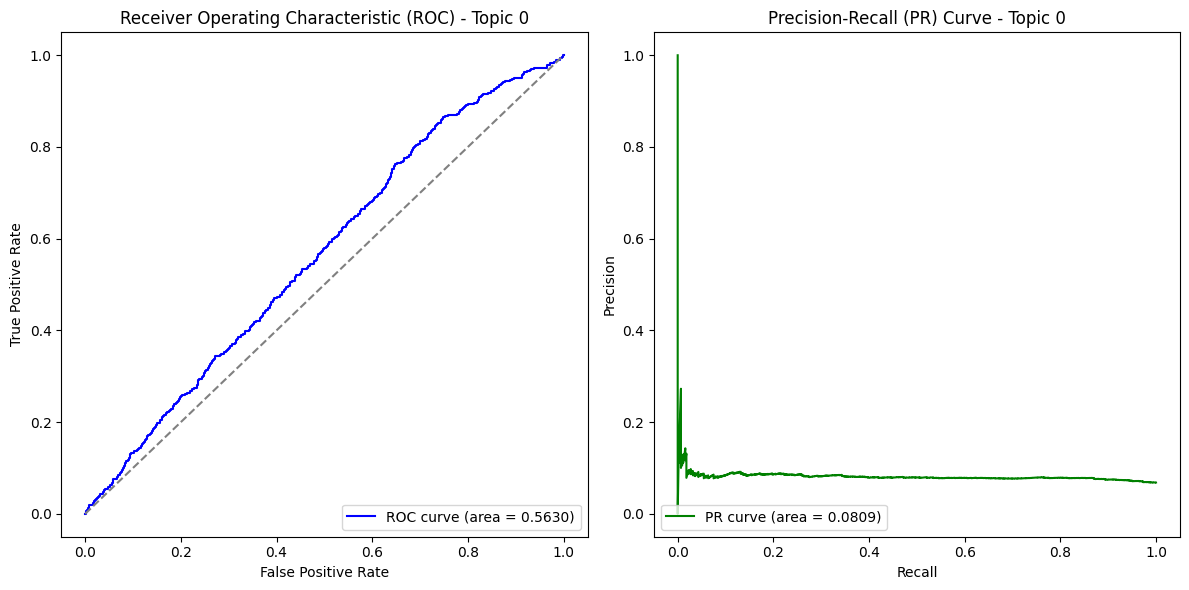

Evaluating topic 1
Topic 1 - auROC: 0.5519, auPR: 0.0766, F1: 0.0000


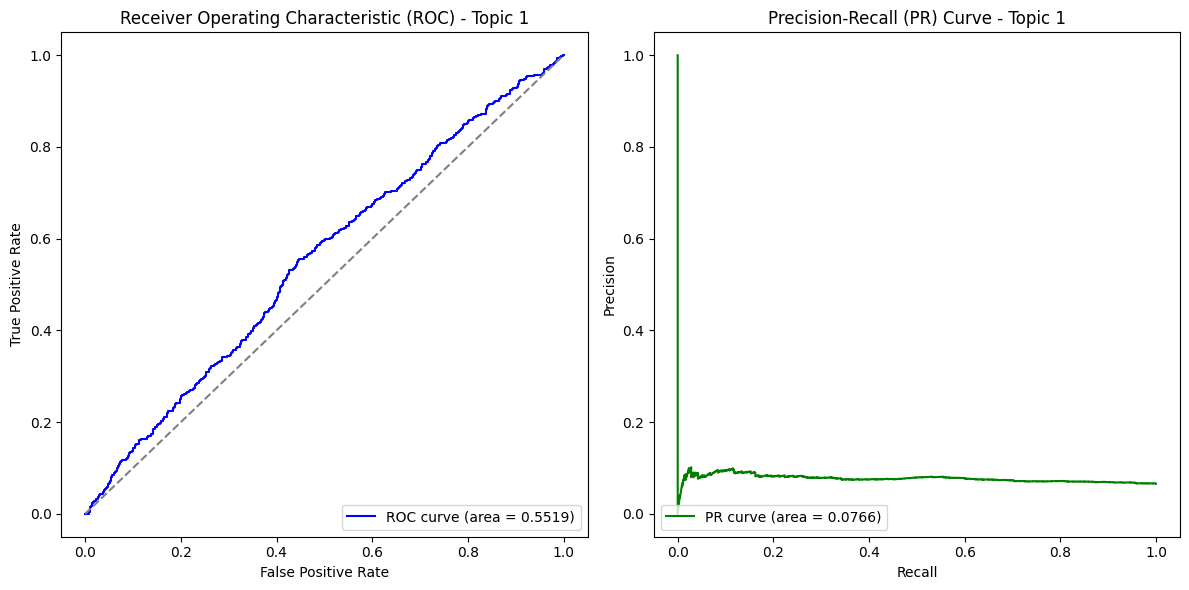

Evaluating topic 2
Topic 2 - auROC: 0.5424, auPR: 0.0809, F1: 0.0268


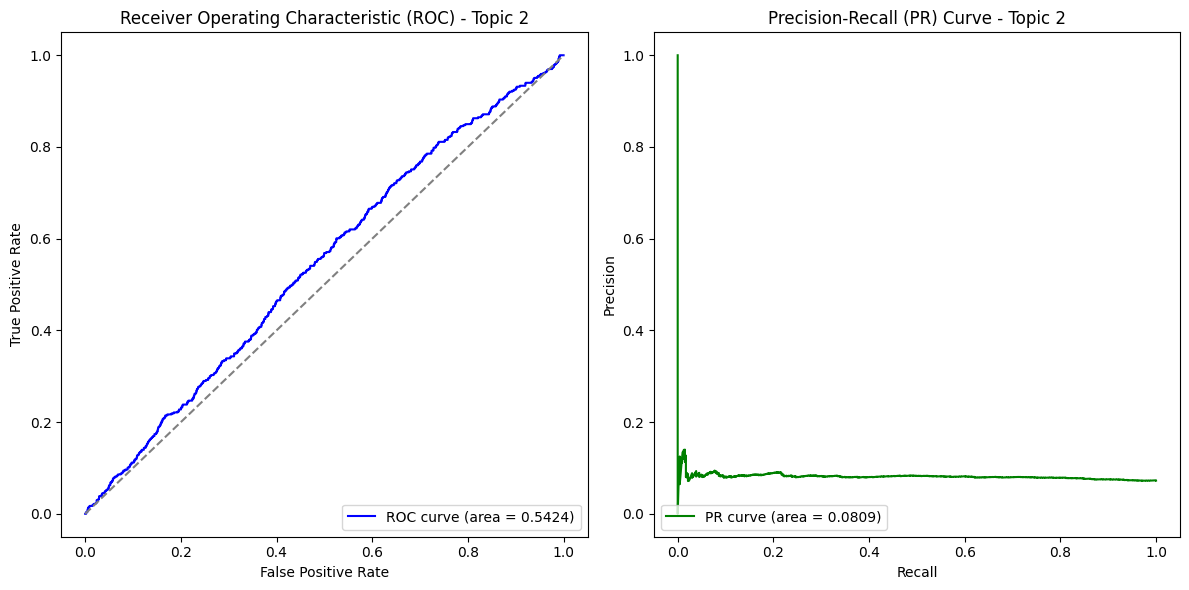

Evaluating topic 3
Topic 3 - auROC: 0.5238, auPR: 0.0772, F1: 0.0189


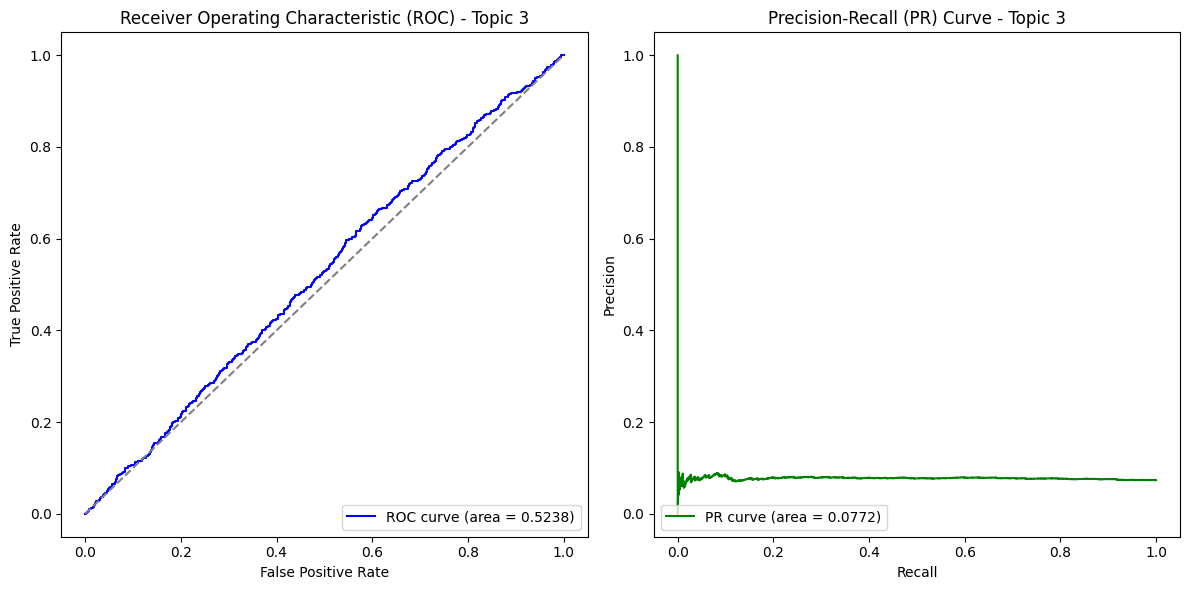

Evaluating topic 4
Topic 4 - auROC: 0.6273, auPR: 0.1122, F1: 0.0464


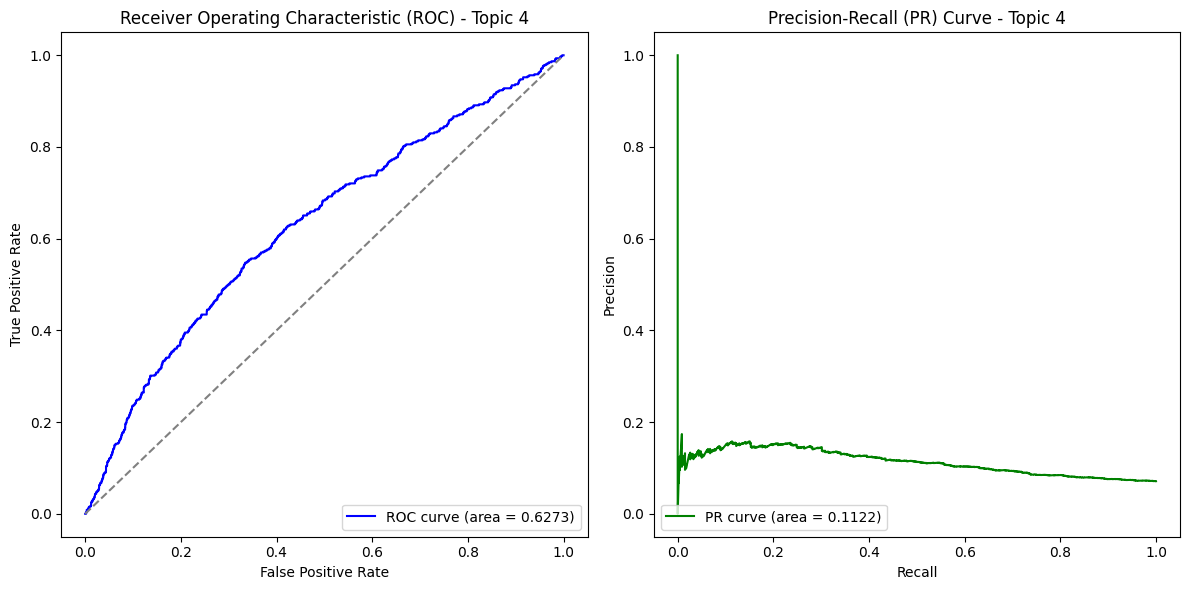

Evaluating topic 5
Topic 5 - auROC: 0.5072, auPR: 0.0677, F1: 0.0168


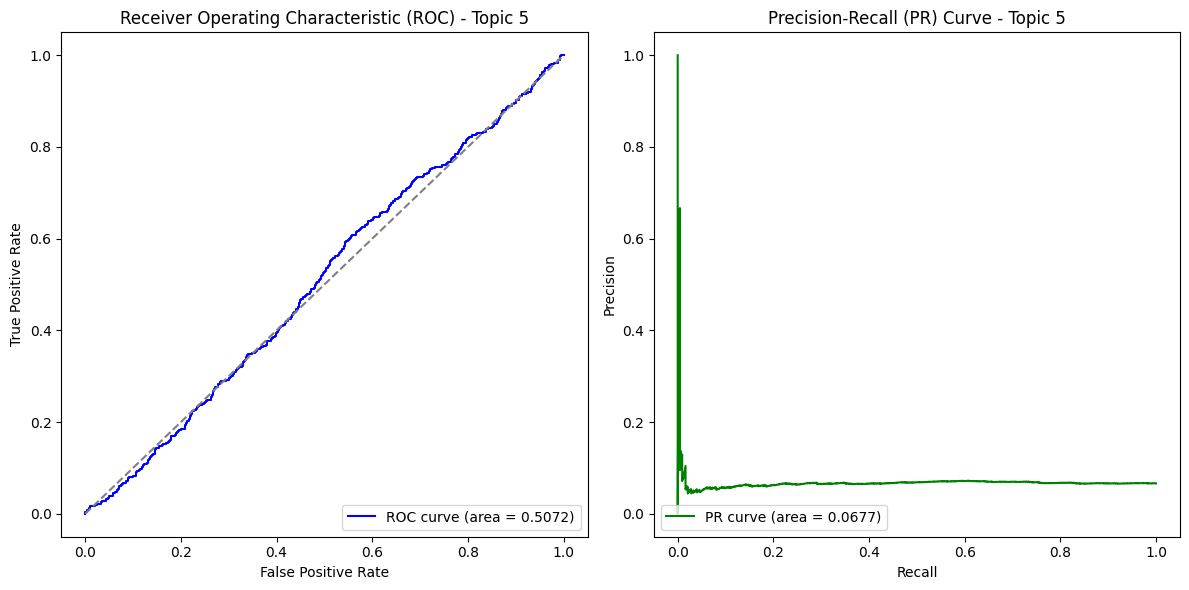

Evaluating topic 6
Topic 6 - auROC: 0.5680, auPR: 0.0864, F1: 0.0157


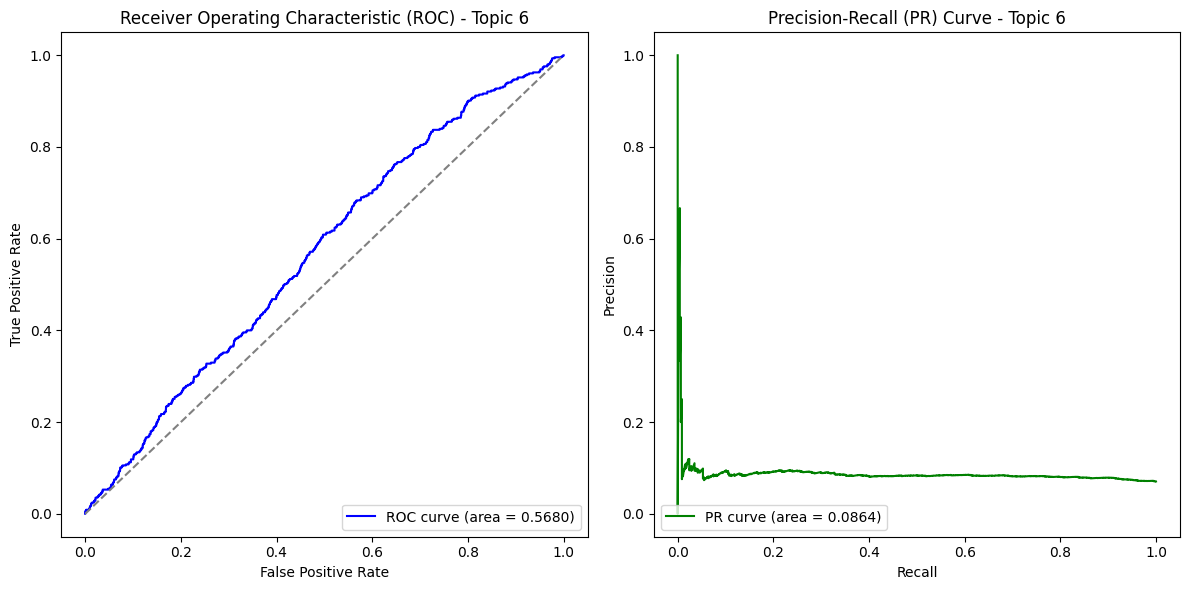

Evaluating topic 7
Topic 7 - auROC: 0.5572, auPR: 0.0830, F1: 0.0239


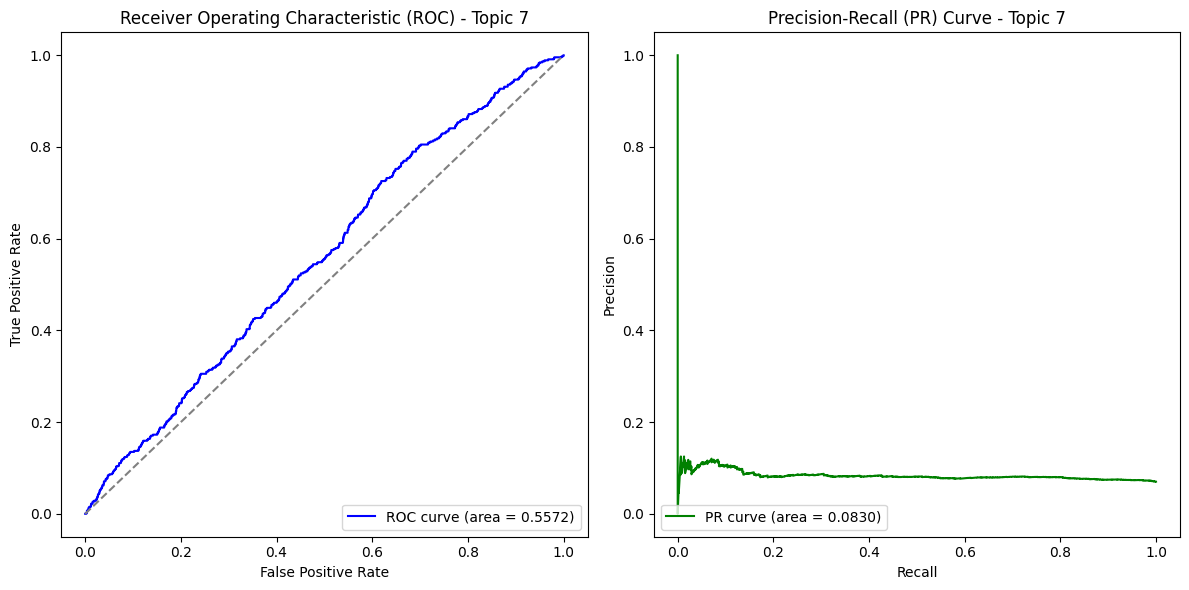

Evaluating topic 8
Topic 8 - auROC: 0.5239, auPR: 0.0776, F1: 0.0312


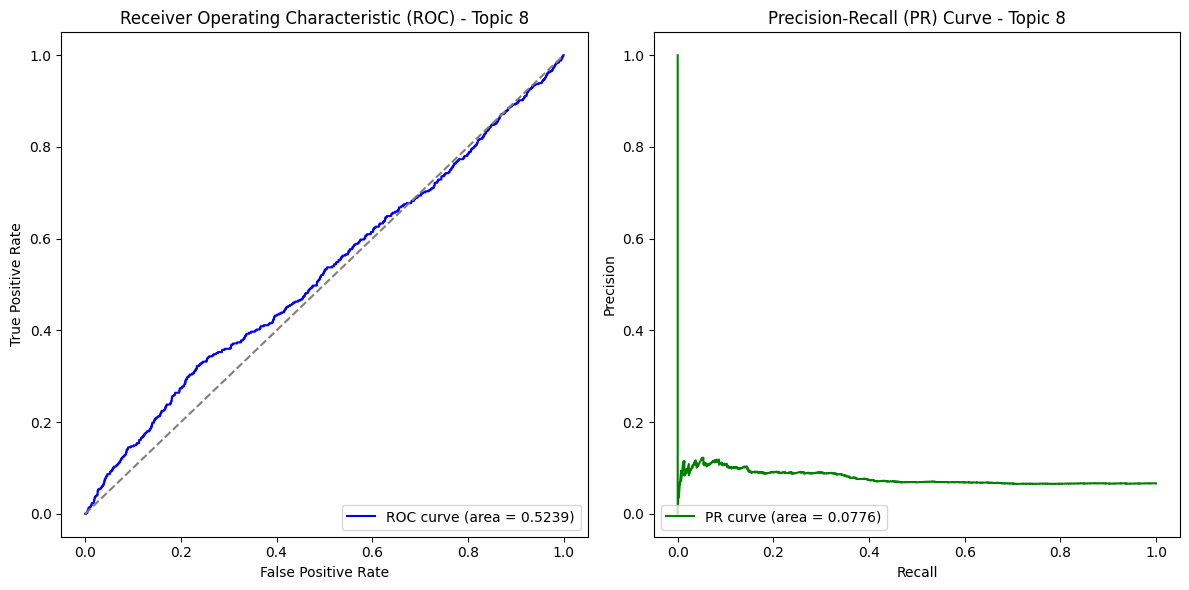

Evaluating topic 9
Topic 9 - auROC: 0.5387, auPR: 0.0772, F1: 0.0159


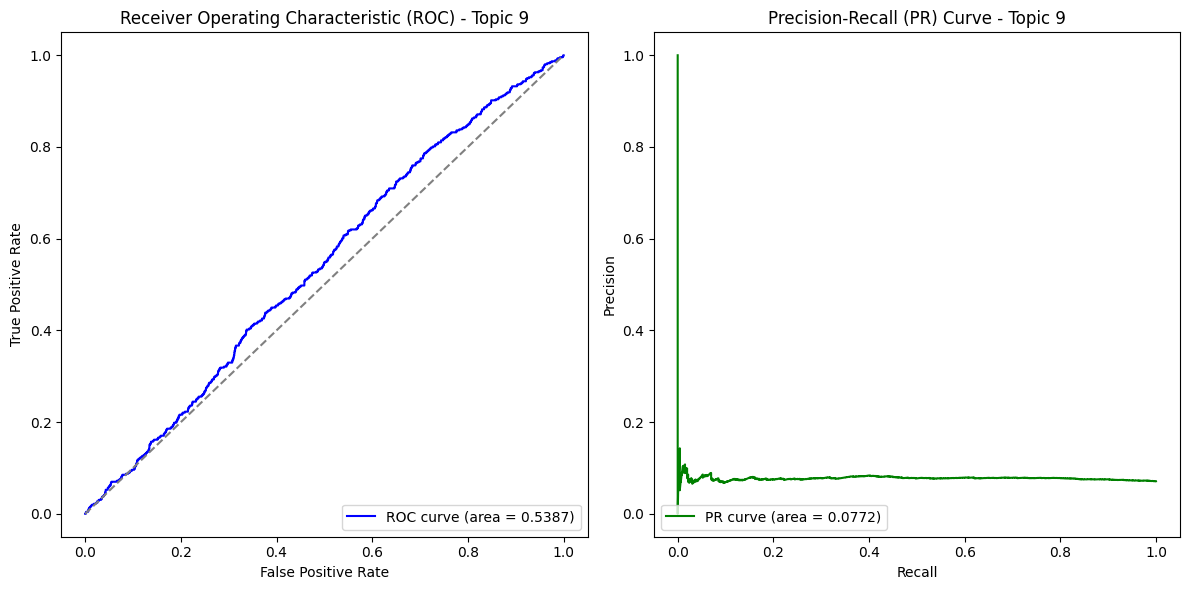

Evaluating topic 10
Topic 10 - auROC: 0.5814, auPR: 0.0885, F1: 0.0478


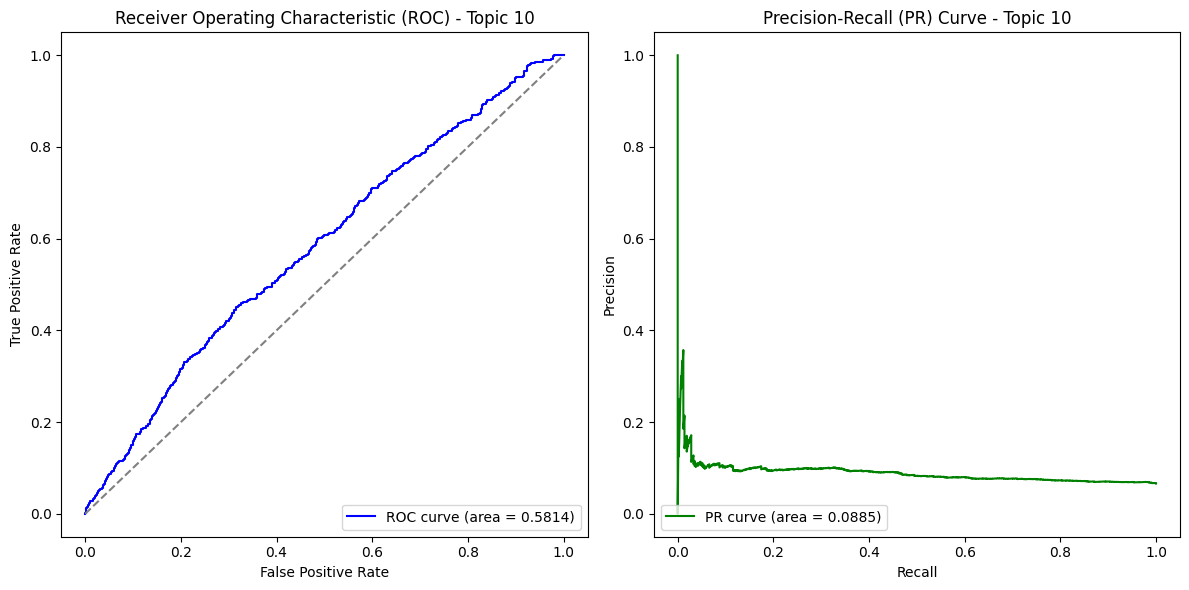

Evaluating topic 11
Topic 11 - auROC: 0.5383, auPR: 0.0852, F1: 0.0232


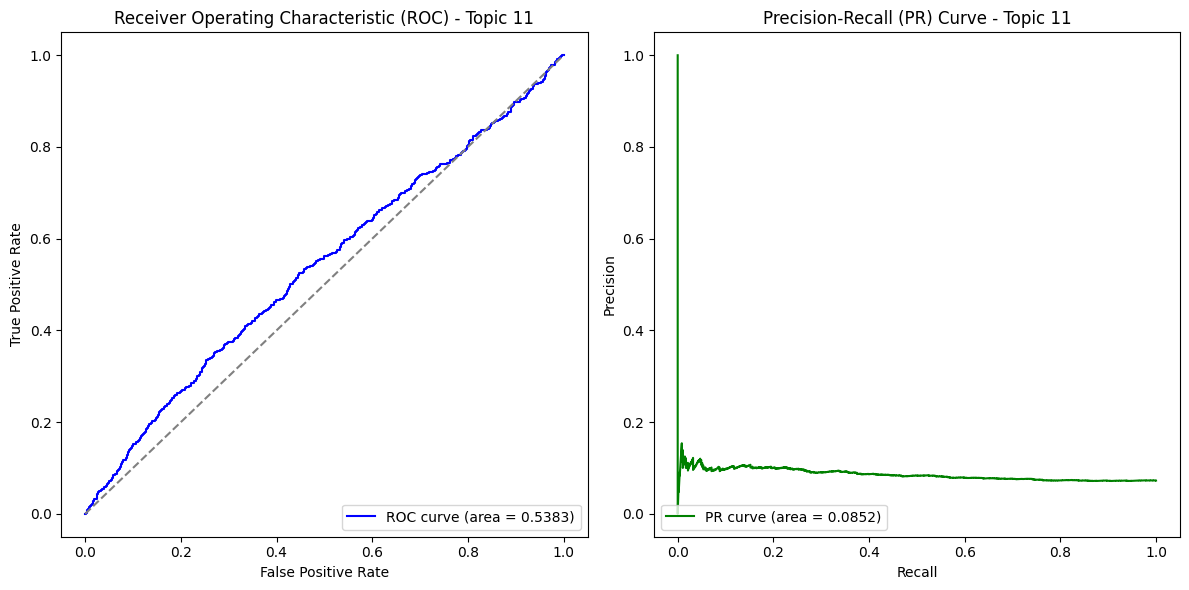

Evaluating topic 12
Topic 12 - auROC: 0.4999, auPR: 0.0664, F1: 0.0203


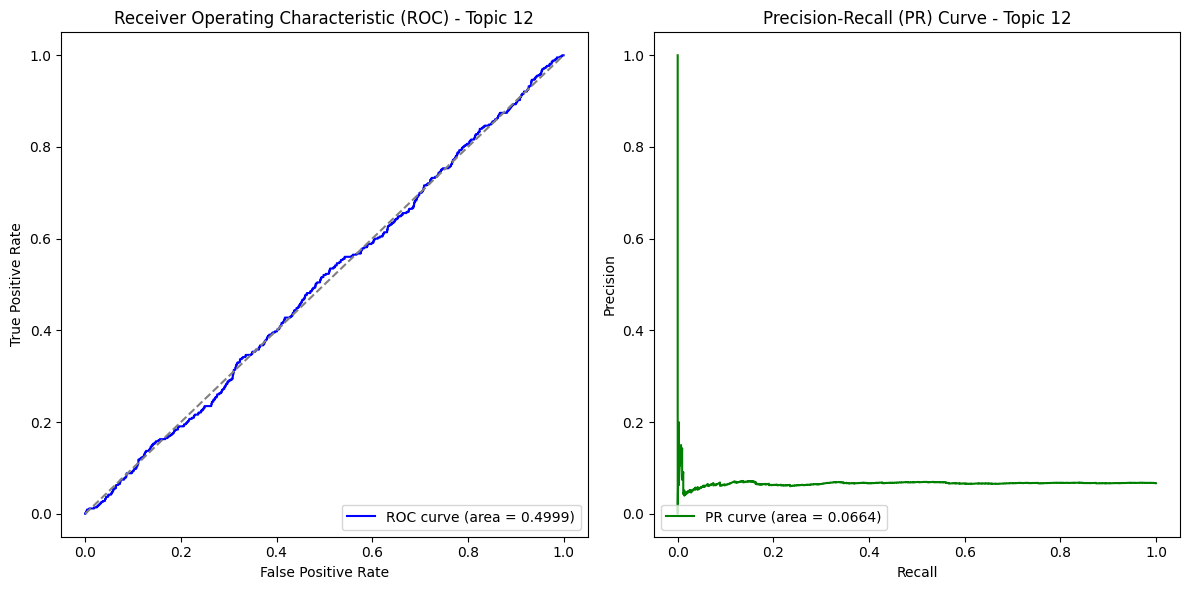

Evaluating topic 13
Topic 13 - auROC: 0.5925, auPR: 0.0966, F1: 0.0191


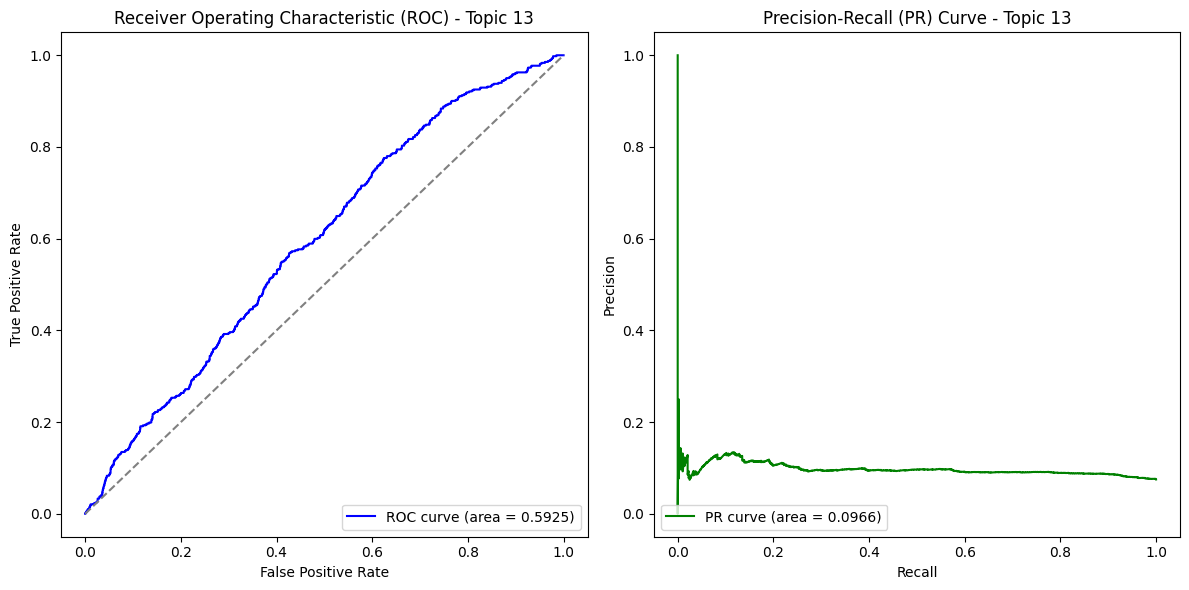

Evaluating topic 14
Topic 14 - auROC: 0.5468, auPR: 0.0857, F1: 0.0304


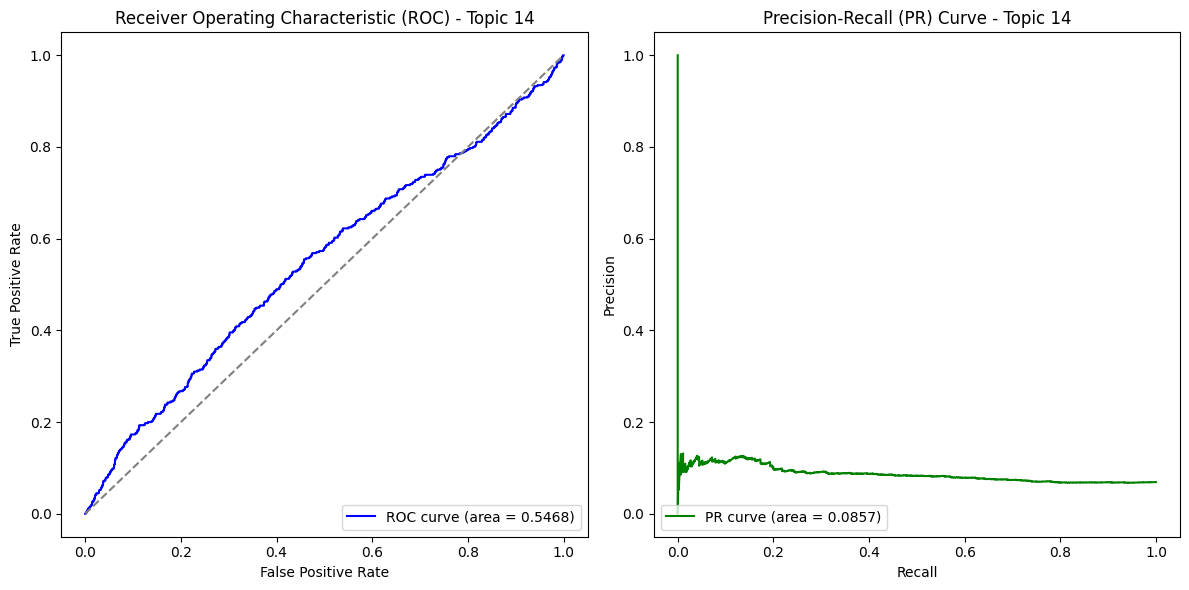

Evaluating topic 15
Topic 15 - auROC: 0.5330, auPR: 0.0804, F1: 0.0120


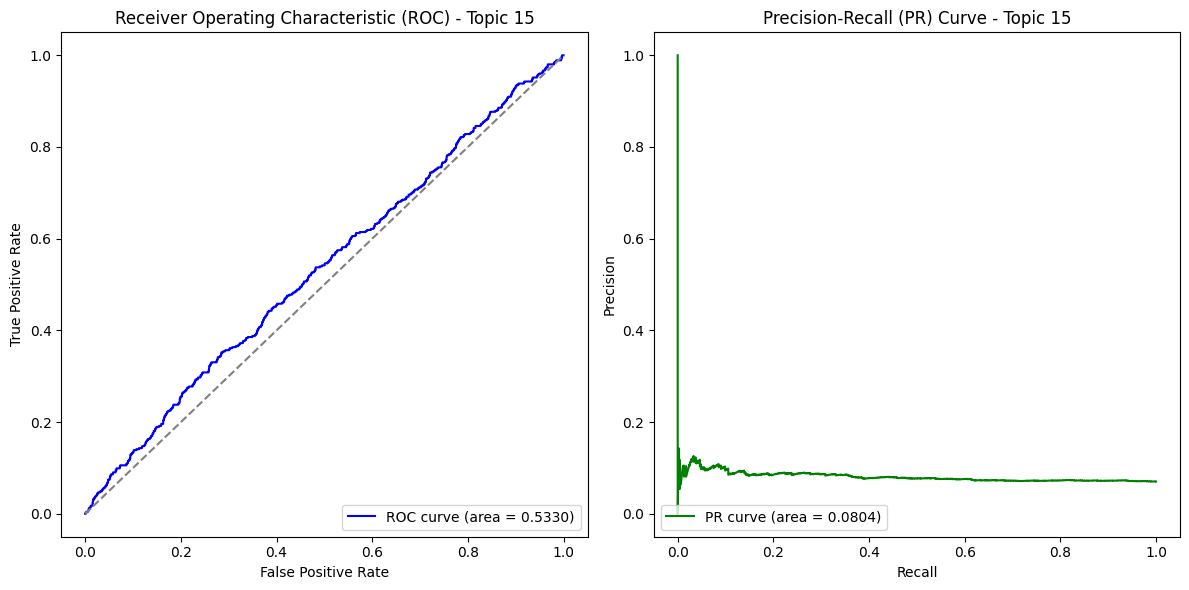

Evaluating topic 16
Topic 16 - auROC: 0.5697, auPR: 0.0839, F1: 0.0305


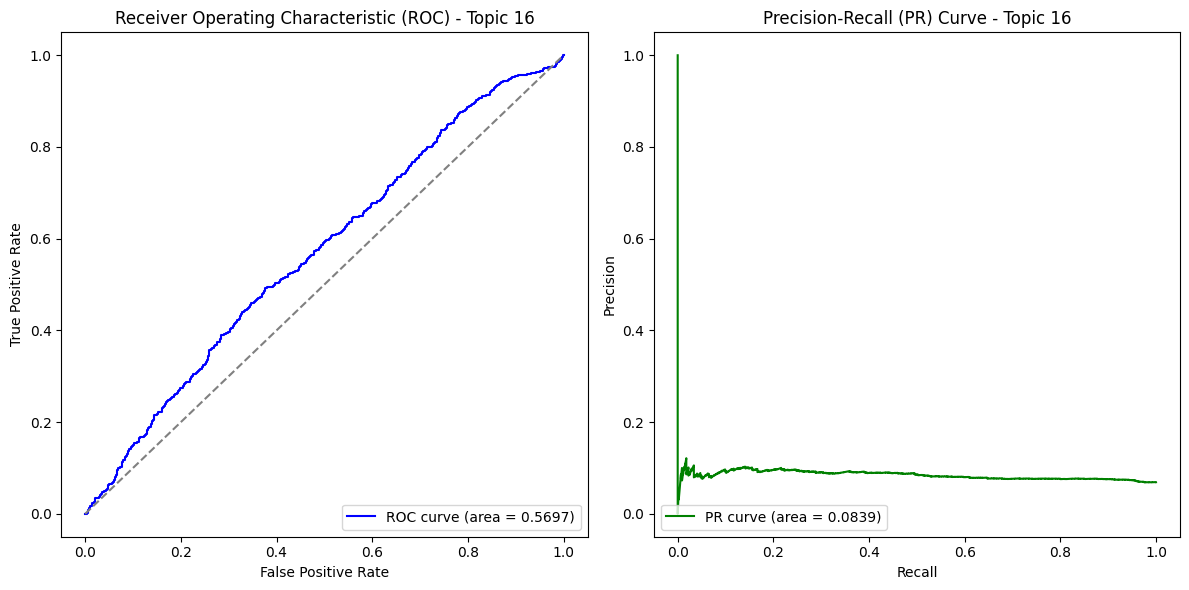

Evaluating topic 17
Topic 17 - auROC: 0.5272, auPR: 0.0813, F1: 0.0118


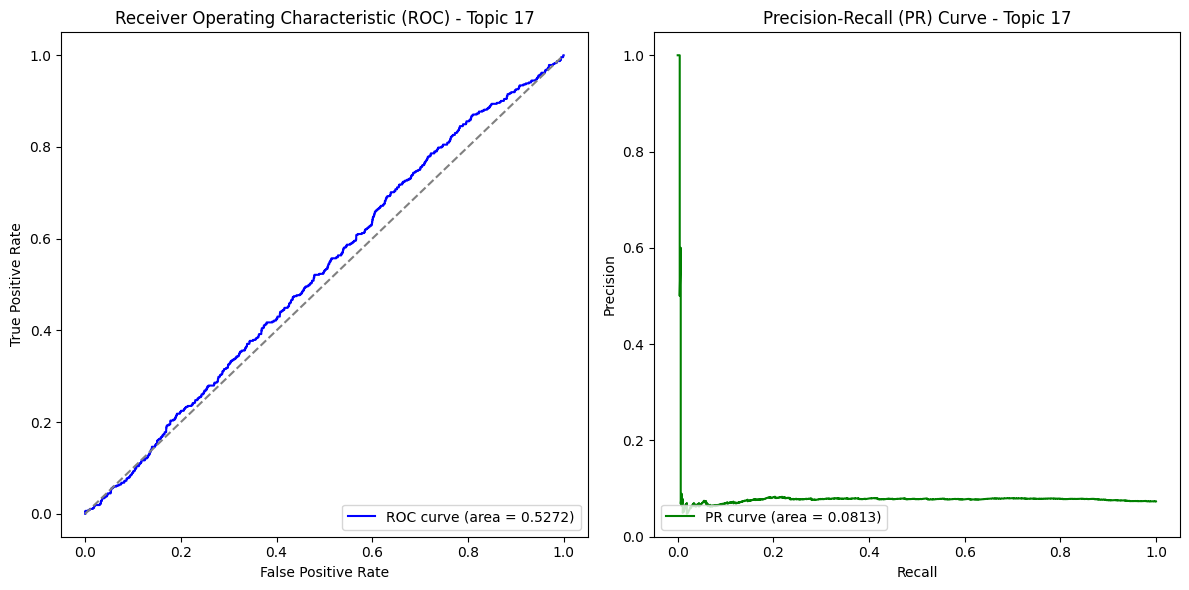

In [22]:
# Evaluate model performance for each topic
num_topics = y_test_np.shape[1]
auroc_values = []
aupr_values = []
f1_scores = []

print(f"\nEvaluating {num_topics} topics...")

for topic_idx in range(num_topics):
    print(f'Evaluating topic {topic_idx}')
    
    # Calculate ROC and PR metrics for the current topic
    fpr, tpr, _ = roc_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    roc_auc = auc(fpr, tpr)
    auroc_values.append(roc_auc)
    
    precision, recall, _ = precision_recall_curve(y_test_np[:, topic_idx], y_pred_np[:, topic_idx])
    pr_auc = auc(recall, precision)
    aupr_values.append(pr_auc)

    # Binarize predictions for F1 score calculation
    y_pred_bin = (y_pred_np[:, topic_idx] >= 0.5).astype(int)
    f1 = f1_score(y_test_np[:, topic_idx], y_pred_bin)
    f1_scores.append(f1)
    
    print(f'Topic {topic_idx} - auROC: {roc_auc:.4f}, auPR: {pr_auc:.4f}, F1: {f1:.4f}')
    
    # Plot ROC and PR curves for the current topic
    plt.figure(figsize=(12, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - Topic {topic_idx}')
    plt.legend(loc='lower right')
    
    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'PR curve (area = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (PR) Curve - Topic {topic_idx}')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()

In [23]:
# Summary statistics
print(f"\nSummary Statistics:")
print(f"Mean auROC: {np.mean(auroc_values):.4f} ± {np.std(auroc_values):.4f}")
print(f"Mean auPR: {np.mean(aupr_values):.4f} ± {np.std(aupr_values):.4f}")
print(f"Mean F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Exact Match Accuracy: {exact_acc:.4f}")
print(f"Hamming Accuracy: {hamming_acc:.4f}")


Summary Statistics:
Mean auROC: 0.5496 ± 0.0303
Mean auPR: 0.0826 ± 0.0099
Mean F1: 0.0233 ± 0.0114
Exact Match Accuracy: 0.0014
Hamming Accuracy: 0.9227


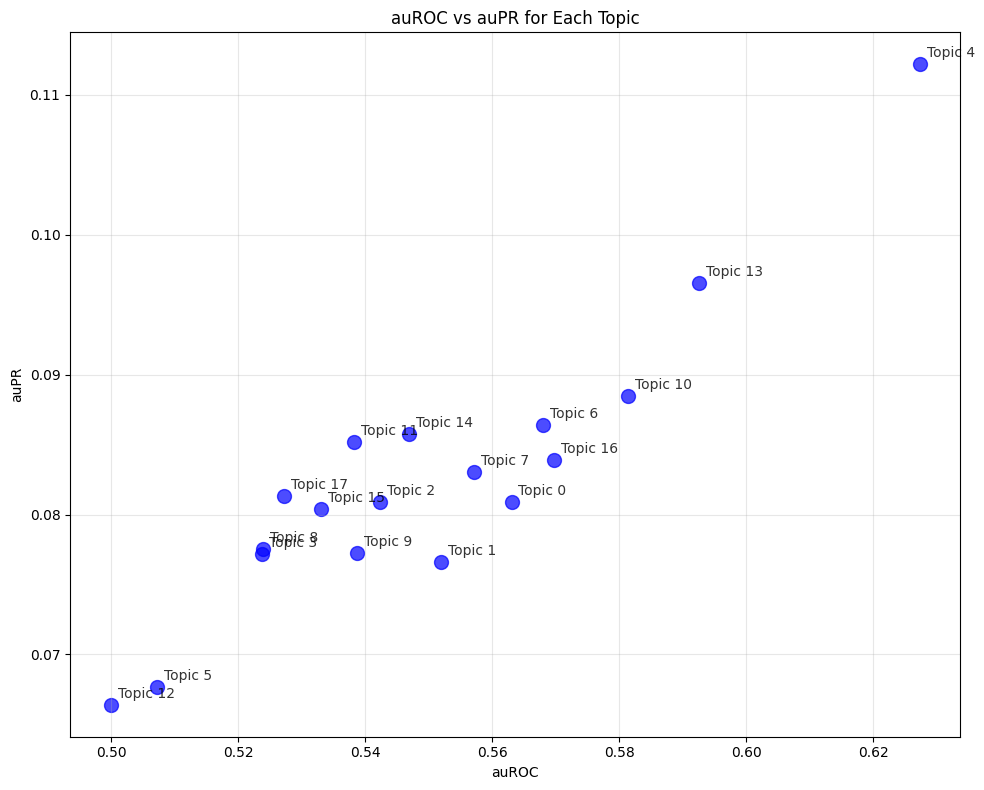

In [24]:
# Scatter plot of auROC vs auPR
plt.figure(figsize=(10, 8))
plt.scatter(auroc_values, aupr_values, color='blue', alpha=0.7, s=100, )
plt.xlabel('auROC')
plt.ylabel('auPR')
plt.title('auROC vs auPR for Each Topic')
plt.grid(True, alpha=0.3)

# Annotate each point with the topic index
for i, (x, y) in enumerate(zip(auroc_values, aupr_values)):
    plt.annotate(f'Topic {i}', (x, y), fontsize=10, alpha=0.8, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

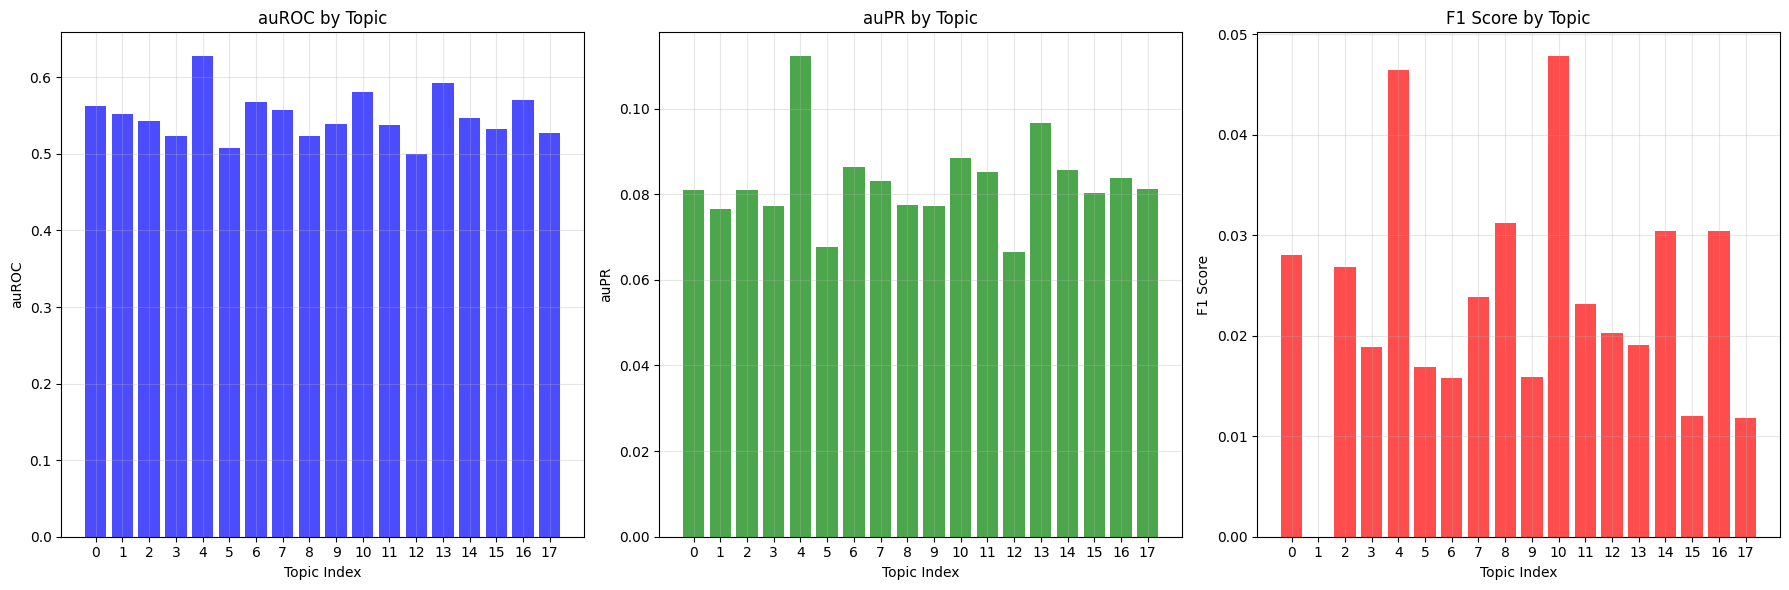

In [25]:
# Bar plots for metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# auROC bar plot
axes[0].bar(range(num_topics), auroc_values, color='blue', alpha=0.7)
axes[0].set_xlabel('Topic Index')
axes[0].set_ylabel('auROC')
axes[0].set_title('auROC by Topic')
axes[0].set_xticks(range(num_topics))
axes[0].grid(True, alpha=0.3)

# auPR bar plot
axes[1].bar(range(num_topics), aupr_values, color='green', alpha=0.7)
axes[1].set_xlabel('Topic Index')
axes[1].set_ylabel('auPR')
axes[1].set_title('auPR by Topic')
axes[1].set_xticks(range(num_topics))
axes[1].grid(True, alpha=0.3)

# F1 bar plot
axes[2].bar(range(num_topics), f1_scores, color='red', alpha=0.7)
axes[2].set_xlabel('Topic Index')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score by Topic')
axes[2].set_xticks(range(num_topics))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

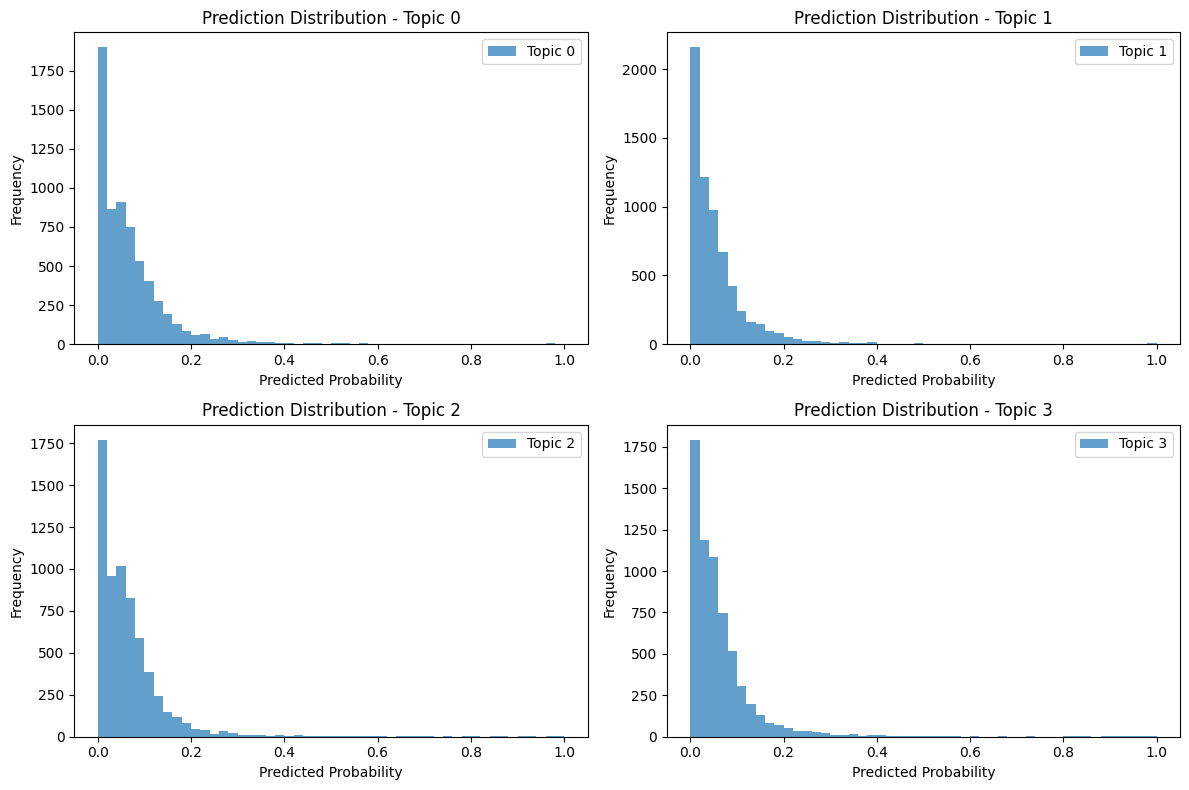


Sample predictions (first 10 samples):
Sample 0:
  Predicted: [0.01333914 0.0130478  0.09540182 0.04391501 0.01020768 0.03693943
 0.0298593  0.11401536 0.07852324 0.0323133  0.03226238 0.05069869
 0.09762104 0.10238174 0.00451606 0.1500784  0.0888477  0.03799877]
  Actual:    [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 1:
  Predicted: [0.12829895 0.00059669 0.15194705 0.0087354  0.06233912 0.00099342
 0.02007369 0.07294372 0.13497348 0.01551237 0.03552204 0.00869827
 0.326415   0.00463904 0.00522822 0.00747305 0.02300362 0.02644421]
  Actual:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  Binary:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Sample 2:
  Predicted: [0.00860251 0.0216937  0.05070186 0.05920954 0.03235481 0.03542714
 0.06753963 0.02143822 0.0275498  0.07134338 0.0496793  0.01322923
 0.09418404 0.03219847 0.08965892 0.11525506 0.14568807 0.13695082]
  Actual:    [0. 0. 0. 0. 1. 0. 0. 1. 0. 0.

In [26]:
# Additional analysis: Prediction distribution
plt.figure(figsize=(12, 8))

# Histogram of predictions for each topic
for i in range(min(4, num_topics)):  # Show first 4 topics
    plt.subplot(2, 2, i+1)
    plt.hist(y_pred_np[:, i], bins=50, alpha=0.7, label=f'Topic {i}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Distribution - Topic {i}')
    plt.legend()

plt.tight_layout()
plt.show()

# Sample predictions vs targets
print("\nSample predictions (first 10 samples):")
for i in range(min(10, y_pred_np.shape[0])):
    print(f"Sample {i}:")
    print(f"  Predicted: {y_pred_np[i]}")
    print(f"  Actual:    {y_test_np[i]}")
    print(f"  Binary:    {(y_pred_np[i] > 0.5).astype(int)}")
    print()